# Analyzing Within Blocks 1 At A Time
By: Adam Li

For each block, separate word pairings into 3 groups: same, reverse, different. Then for each word_pair obtain a distribution of features for each event in that word_pair. Compare distributions:
    
    i) same vs. same (control) (n=4)
    ii) same vs. reverse (n=1)
    iii) same vs. different (n=4)

Then we should see that there are only about 0.05*9 significant showings across each channel and only about 5% of channels are significant. If there are more, we can investigate why these channels are different.

We will get a p-value matrix of 3x96 by clumping all same

In [1]:
# Import Necessary Libraries
import numpy as np
import scipy.io

import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable


from sklearn.decomposition import PCA
import scipy.stats as stats
from scipy.spatial import distance as Distance

# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

%matplotlib inline

In [2]:
### Functions to help extract features and plot histogram of distances
# loops through each wordpairing group and extract features
def extractFeaturesForChannel(wordgroup, session, block, block_dir, channel, freq_bands):
    PairFeatureDict = {}
    for idx, pairs in enumerate(wordgroup):
        # load in data
        first_wordpair_dir = block_dir + '/' + pairs[0]
        second_wordpair_dir = block_dir + '/' + pairs[1]

        # initialize np arrays for holding feature vectors for each event
        first_pair_features = []
        second_pair_features = []

        # load in channels for each 
        channels = os.listdir(first_wordpair_dir)
        # loop through channels
#         for jdx, chans in enumerate(channels):
        chans = channel
        jdx = 0
        # Each wordpair's fullfile dir path
        first_chan_file = first_wordpair_dir + '/' + chans
        second_chan_file = second_wordpair_dir + '/' + chans

        ## 0: load in data
        data_first = scipy.io.loadmat(first_chan_file)
        data_first = data_first['data']
        data_second = scipy.io.loadmat(second_chan_file)
        data_second = data_second['data']

        ## 01: get the time point for probeword on
        first_timeZero = data_first['timeZero'][0][0][0]
        second_timeZero = data_second['timeZero'][0][0][0]

        ## 02: get the time point of vocalization
        first_vocalization = data_first['vocalization'][0][0][0]
        second_vocalization = data_second['vocalization'][0][0][0]

        ## 03: Get Power Matrix
        first_matrix = data_first['powerMatZ'][0][0]
        second_matrix = data_second['powerMatZ'][0][0]
        first_matrix = first_matrix[:,freq_bands,:]
        second_matrix = second_matrix[:,freq_bands,:]

        ### 1: get only the time point before vocalization
        first_mean = []
        second_mean = []
        for i in range(0, len(first_vocalization)):
            # either go from timezero -> vocalization, or some other timewindow
            first_mean.append(np.ndarray.flatten(np.mean(first_matrix[i,:,first_vocalization[i]-num_time_windows:first_vocalization[i]-1],axis=1)))

        for i in range(0, len(second_vocalization)):
            second_mean.append(np.ndarray.flatten(np.mean(second_matrix[i,:,second_vocalization[i]-num_time_windows:second_vocalization[i]-1], axis=1)))

#         print second_timeZero, second_vocalization[i]
#         print np.array(first_mean).shape
#         print np.array(second_mean).shape
        
        # create feature vector for each event
        if jdx == 0:
            first_pair_features.append(first_mean)
            second_pair_features.append(second_mean)
            first_pair_features = np.squeeze(np.array(first_pair_features))
            second_pair_features = np.squeeze(np.array(second_pair_features))
        else:
            first_pair_features = np.concatenate((first_pair_features, first_mean), axis=1)
            second_pair_features = np.concatenate((second_pair_features, second_mean), axis=1)
        # end of loop through channels
        
        # should be #events X #features (channels x freq. bands x time points)
#         if idx==0:
#             print first_pair_features.shape
#             print second_pair_features.shape
        
        # add to overall dictionary for each comparison word for return statement at end
        pairName = pairs[0] + 'vs' + pairs[1]
        PairFeatureDict[pairName] = []
        PairFeatureDict[pairName].append(first_pair_features)
        PairFeatureDict[pairName].append(second_pair_features)
        
    return PairFeatureDict
 
# Compute all pairwise distances between first_mat to second_mat
def computePairDistances(first_mat, second_mat):
    distance_list = []
    for idx in range(0, first_mat.shape[0]):
        distance_list.append([distances(x, first_mat[idx,:]) for x in second_mat])
    distance_list = np.ndarray.flatten(np.array(distance_list))
    return distance_list  

def computePairRepeatedDistances(first_mat, second_mat):
    distance_list = np.array(())
    for idx in range(0, first_mat.shape[0]):
        second_mat = np.delete(second_mat, 0, 0)
        to_append = np.array([distances(x, first_mat[idx,:]) for x in second_mat])
        distance_list = np.append(distance_list, to_append, axis=0)
    distance_list = np.array(distance_list)
    distance_list = np.ndarray.flatten(np.array(distance_list))
    return distance_list

def isReverse(pair1, pair2):
    pair1split = pair1.split('_')
    pair2split = pair2.split('_')
    if pair1split[0] == pair2split[1] and pair1split[1] == pair2split[0]:
        return True
    else:
        return False

In [3]:
################################### HYPER-PARAMETERS TO TUNE #######################################################
anova_threshold = 90   # how many channels we want to keep
distances = Distance.cosine # define distance metric to use
num_time_windows = 15
low_freq_bands = [0, 1]
high_freq_bands = [3, 4, 5, 6]
freq_bands = np.arange(0,7,1)

np.random.seed(123456789)  # for reproducibility, set random seed

freq_labels = ['delta', 'theta', 'alpha', 'beta', 'low gamma', 'high gamma', 'HFO']
# print freq_bands
# print [freq_labels[i] for i in freq_bands]

print 'low bands: ', [freq_labels[i] for i in low_freq_bands]
print 'high bands: ', [freq_labels[i] for i in high_freq_bands]
print "The length of the feature vector for each channel will be: ", num_time_windows*len(freq_bands), \
            ' total=', 96*num_time_windows*len(freq_bands)

low bands:  ['delta', 'theta']
high bands:  ['beta', 'low gamma', 'high gamma', 'HFO']
The length of the feature vector for each channel will be:  105  total= 10080


Analyzing session  session_1
Analyzing block  BLOCK_0
These are the wordpairs in this block:  ['BRICK_CLOCK', 'CLOCK_BRICK', 'GLASS_JUICE', 'JUICE_GLASS']
Analyzing block  BLOCK_1
These are the wordpairs in this block:  ['BRICK_CLOCK', 'CLOCK_BRICK', 'GLASS_PANTS', 'PANTS_GLASS']
Analyzing block  BLOCK_2
These are the wordpairs in this block:  ['BRICK_JUICE', 'GLASS_PANTS', 'JUICE_BRICK', 'PANTS_GLASS']
Analyzing block  BLOCK_3
These are the wordpairs in this block:  ['BRICK_JUICE', 'CLOCK_GLASS', 'GLASS_CLOCK', 'JUICE_BRICK']
Analyzing block  BLOCK_4
These are the wordpairs in this block:  ['BRICK_PANTS', 'CLOCK_GLASS', 'GLASS_CLOCK', 'PANTS_BRICK']
Analyzing block  BLOCK_5
These are the wordpairs in this block:  ['BRICK_PANTS', 'GLASS_JUICE', 'JUICE_GLASS', 'PANTS_BRICK']
old shape of session pval matrix:  (576,)
new shape of session pval matrix:  (6, 96)
Analyzing session  session_2
Analyzing block  BLOCK_0
These are the wordpairs in this block:  ['BRICK_CLOCK', 'CLOCK_BRICK', 'GLAS

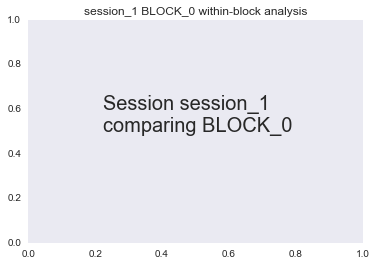

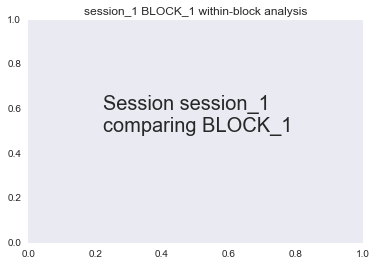

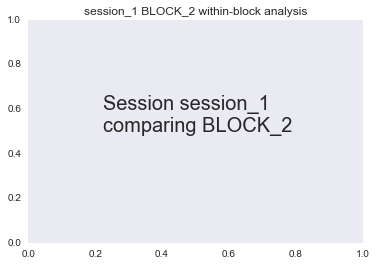

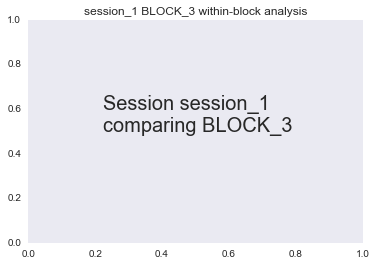

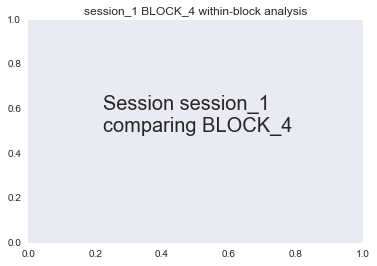

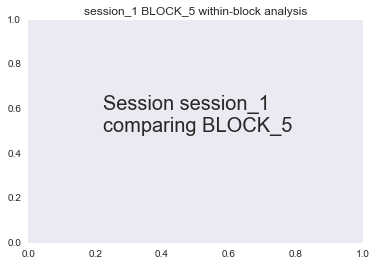

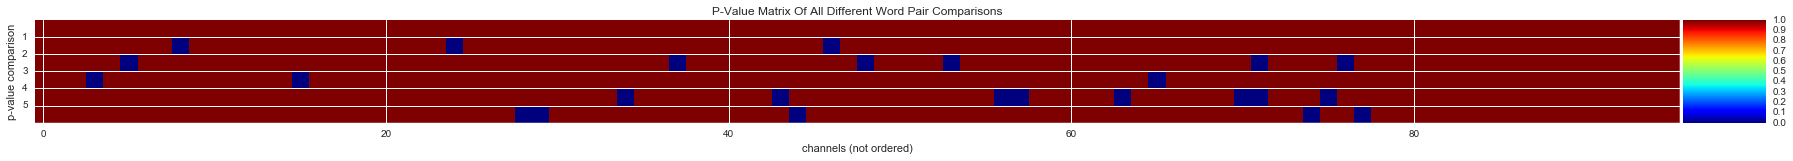

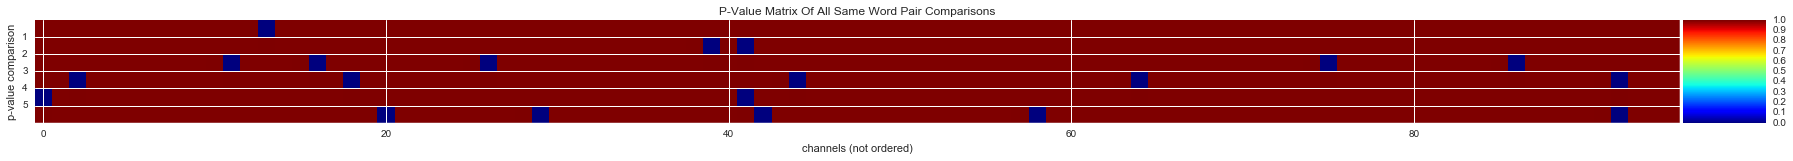

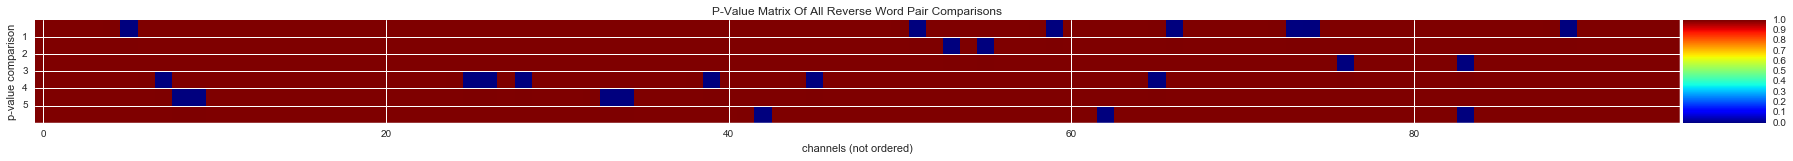

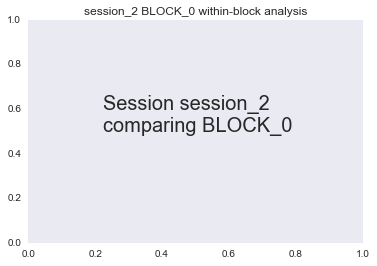

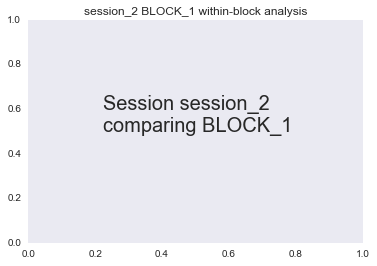

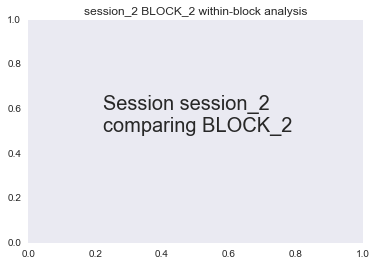

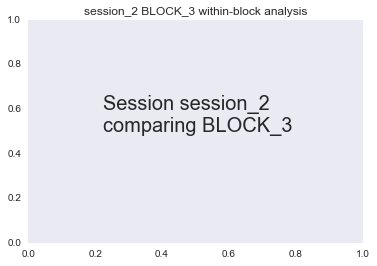

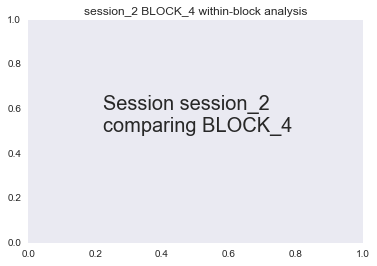

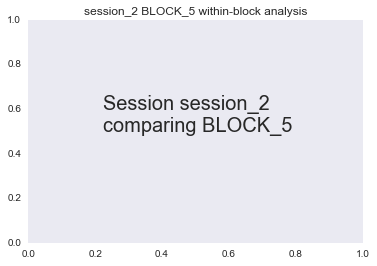

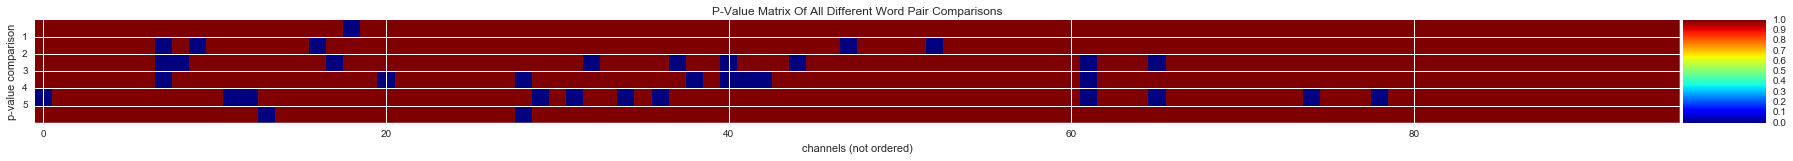

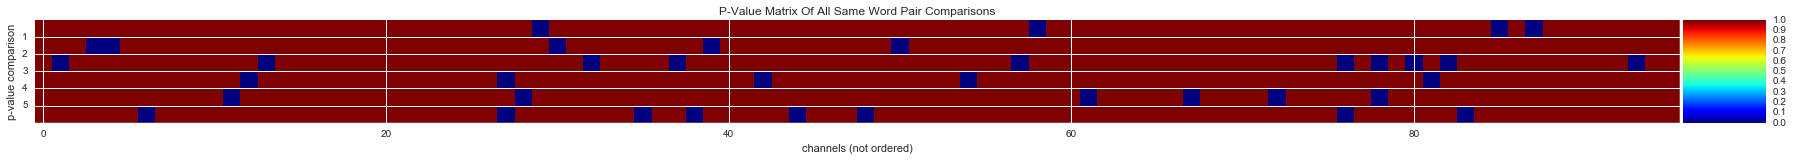

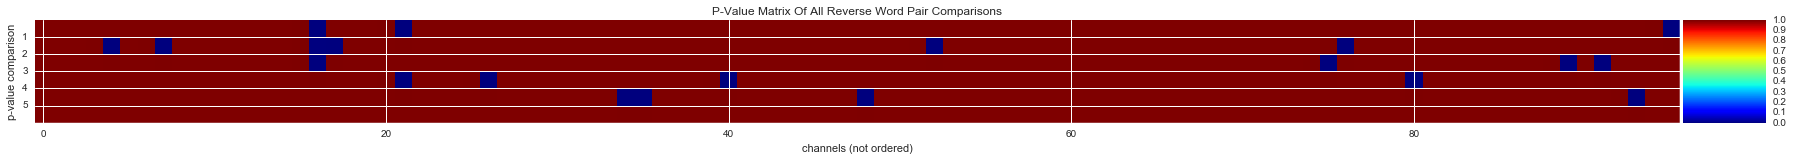

In [20]:
######## Get list of files (.mat) we want to work with ########
filedir = '../condensed_data/blocks/'
sessions = os.listdir(filedir)
sessions = sessions[2:]

session_pval_dict = {}
# loop through each session
for session in sessions:
    print "Analyzing session ", session
    sessiondir = filedir + session
    
    # get all blocks for this session
    blocks = os.listdir(sessiondir)
    
    if len(blocks) != 6: # error check on the directories
        print blocks
        print("Error in the # of blocks. There should be 5.")
        break
    
    session_pval_mat = np.array(())
    session_pval_same_mat = np.array(())
    session_pval_reverse_mat = np.array(())
    
    # loop through each block one at a time, analyze
    for i in range(0, 6):
        print "Analyzing block ", blocks[i]
        block = blocks[i]
        block_dir = sessiondir + '/' + block
        
        # in each block, get list of word pairs from first and second block
        wordpairs = os.listdir(block_dir)
       
        # within-groups analysis only has: SAME, REVERSE, DIFFERENT
        diff_word_group = []
        reverse_word_group = []
        same_word_group = []
        
        print "These are the wordpairs in this block: ", wordpairs
         
        #### plot meta information about which session and blocks we're analyzing
        fig=plt.figure()
        axes = plt.gca()
        ymin, ymax = axes.get_ylim()
        xmin, xmax = axes.get_xlim()
        plt.text((xmax-xmin)/4.5, (ymax-ymin)/2, r'Session %s %scomparing %s'%(session, '\n',block), fontsize=20)
        plt.title(session + ' ' + block + ' within-block analysis')
        plt.grid(False)
        
        ## 01: Create WordPair Groups
        # create same group pairs
        for idx, pair in enumerate(wordpairs):
            same_word_group.append([pair, pair])
        
        # create reverse, and different groups
        for idx, pairs in enumerate(itertools.combinations(wordpairs,2)):
            if isReverse(pairs[0], pairs[1]):
                reverse_word_group.append([pairs[0], pairs[1]])
            else:
                diff_word_group.append([pairs[0], pairs[1]])
        
        channels = os.listdir(block_dir+'/'+same_word_group[0][0])
        
        session_block_pval_dict = {}
        session_block_pval_mat = np.array(())
        session_block_pval_same_mat = np.array(())
        session_block_pval_reverse_mat = np.array(())
        ## 02: Create feature_dicts from each channel
        for jdx, chan in sorted(enumerate(channels)):
            ### Go through each group and extract the feature data for each wordpair comparison
            same_feature_dict = extractFeaturesForChannel(same_word_group,session,block,block_dir, chan, low_freq_bands)
            reverse_feature_dict = extractFeaturesForChannel(reverse_word_group,session,block,block_dir, chan, low_freq_bands)
            diff_feature_dict = extractFeaturesForChannel(diff_word_group,session,block,block_dir, chan, low_freq_bands)

#             print 'Done Extracting Feature Data Into Dictionaries for channel: ', chan

            same_distances = np.array(())
            reverse_distances = np.array(())
            diff_distances = np.array(())
            ######################################## SAME WORD PAIRS ########################################
            p_val = 0
            anova_list = {}
#             print 'Analyzing same word pairs...'
            for idx, comp in enumerate(same_feature_dict.keys()):
                distance_hist = computePairRepeatedDistances(same_feature_dict[comp][0], same_feature_dict[comp][1])
                distance_hist = 1-distance_hist

                # append all same_group's distance comparisons into 1 vector
                same_distances = np.append(same_distances, distance_hist, axis=0)
                anova_list[str(idx)] = distance_hist
#                 print "Analyzing ", comp

            # perform ANOVA on same groups
#             print anova_list.keys()
            stat, p_val = stats.f_oneway(anova_list['0'], anova_list['1'], anova_list['2'], anova_list['3'])
#             print "Same groups ANOVA has p-val: ", p_val

            ######################################## REVERSED WORD PAIRS ########################################
            stat_pair_list = {}
#             print 'Analyzing reverse word pairs...'
            for idx, comp in enumerate(reverse_feature_dict.keys()):
                distance_hist = 1-computePairDistances(reverse_feature_dict[comp][0], reverse_feature_dict[comp][1])
#                 print "Analyzing ", comp

                stat_pair_list[str(idx)] = distance_hist
                reverse_distances = np.append(reverse_distances, distance_hist)

            # perform Wilcoxon
            stat, p_val = stats.ranksums(stat_pair_list['0'], stat_pair_list['1'])
#             print stat_pair_list.keys()
#             print "Reverse groups Wilcoxon Signed Rank Test has p-val: ", p_val

            ####################################### DIFFERENT WORD PAIRS ########################################
            anova_list = {}
#             print 'Analyzing different word pairs...'
            for idx, comp in enumerate(diff_feature_dict.keys()):
                distance_hist = 1-computePairDistances(diff_feature_dict[comp][0], diff_feature_dict[comp][1])
#                 print "Analyzing ", comp

                anova_list[str(idx)] = distance_hist
                diff_distances = np.append(diff_distances, distance_hist)

            # perform ANOVA on same groups
#             print anova_list.keys()
            stat, p_val = stats.f_oneway(anova_list['0'], anova_list['1'], anova_list['2'], anova_list['3'])
#             print "Different groups ANOVA has p-val: ", p_val
        
#             print same_distances.shape
#             print reverse_distances.shape
#             print diff_distances.shape
            ##### RUN STATS COMPARISONS ON SAME VS. REVERSE, SAME VS. DIFF, 
            random_subset = np.random.choice(range(same_distances.shape[0]), size=len(same_distances)/2, replace=False)
            random_subset2 = list(set(np.arange(0, len(same_distances))) - set(random_subset))
            same_X = same_distances[random_subset]
            same_Y = same_distances[random_subset2]
#             print random_subset2

            ## perform ks 2-sample test
#             stat, same_p_val = stats.ks_2samp(same_X, same_Y)
#             stat, reverse_p_val = stats.ks_2samp(same_distances, reverse_distances)
#             stat, diff_p_val = stats.ks_2samp(same_distances, diff_distances)
            
            ## perform t-test
            stat, same_p_val = stats.ttest_ind(same_X, same_Y)
            stat, reverse_p_val = stats.ttest_ind(same_distances, reverse_distances)
            stat, diff_p_val = stats.ttest_ind(same_distances, diff_distances)
            
            session_block_pval_mat = np.append(session_block_pval_mat, diff_p_val)
            session_block_pval_same_mat = np.append(session_block_pval_same_mat, same_p_val)
            session_block_pval_reverse_mat = np.append(session_block_pval_reverse_mat, reverse_p_val)
            
#             session_block_pval_dict[chan] = np.array(())
#             session_block_pval_dict[chan] = np.append(session_block_pval_dict[chan], np.array((same_p_val, reverse_p_val, diff_p_val)))
#             session_block_pval_mat = np.concatenate((session_block_pval_mat, np.array((same_p_val, reverse_p_val, diff_p_val))))
            
#         print session_block_pval_mat.shape
        session_block_pval_mat = np.reshape(session_block_pval_mat, (session_block_pval_mat.shape[0]/96, 96))
        session_block_pval_same_mat = np.reshape(session_block_pval_same_mat, (session_block_pval_same_mat.shape[0]/96, 96))
        session_block_pval_reverse_mat = np.reshape(session_block_pval_reverse_mat, (session_block_pval_reverse_mat.shape[0]/96, 96))
#         print session_block_pval_mat.shape
        
        ## append block p-values to session level p-value matrix
        session_pval_mat = np.append(session_pval_mat, session_block_pval_mat)
        session_pval_same_mat = np.append(session_pval_same_mat, session_block_pval_same_mat)
        session_pval_reverse_mat = np.append(session_pval_reverse_mat, session_block_pval_reverse_mat)
        
#         break # look at 1 block
    print 'old shape of session pval matrix: ', session_pval_mat.shape
    session_pval_mat = np.reshape(session_pval_mat, (session_pval_mat.shape[0]/96, 96))
    session_pval_same_mat = np.reshape(session_pval_same_mat, (session_pval_same_mat.shape[0]/96, 96))
    session_pval_reverse_mat = np.reshape(session_pval_reverse_mat, (session_pval_reverse_mat.shape[0]/96, 96))
    print 'new shape of session pval matrix: ', session_pval_mat.shape

    buff = session_pval_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0

    fig=plt.figure(figsize=(25,60))
    ax=plt.gca()
    im = plt.imshow(buff, interpolation='none', cmap='jet')
    plt.xlabel('channels (not ordered)')
    plt.ylabel('p-value comparison')
    plt.title('P-Value Matrix Of All Different Word Pair Comparisons')
    plt.yticks(np.arange(0.5,6,1), np.arange(1, 6, 1))
    vmin, vmax = plt.gci().get_clim()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    
    buff = session_pval_same_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0

    fig=plt.figure(figsize=(25,60))
    ax=plt.gca()
    im = plt.imshow(buff, interpolation='none', cmap='jet')
    plt.xlabel('channels (not ordered)')
    plt.ylabel('p-value comparison')
    plt.title('P-Value Matrix Of All Same Word Pair Comparisons')
    plt.yticks(np.arange(0.5,6,1), np.arange(1, 6, 1))
    vmin, vmax = plt.gci().get_clim()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    
    buff = session_pval_reverse_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0

    fig=plt.figure(figsize=(25,60))
    ax=plt.gca()
    im = plt.imshow(buff, interpolation='none', cmap='jet')
    plt.xlabel('channels (not ordered)')
    plt.ylabel('p-value comparison')
    plt.title('P-Value Matrix Of All Reverse Word Pair Comparisons')
    plt.yticks(np.arange(0.5,6,1), np.arange(1, 6, 1))
    vmin, vmax = plt.gci().get_clim()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    
    session_pval_dict[session] = {}
    session_pval_dict[session]['same'] = session_pval_same_mat
    session_pval_dict[session]['reverse'] = session_pval_reverse_mat
    session_pval_dict[session]['diff'] = session_pval_mat
    
#     break # look at 1 session

In [21]:
session_chan_data = session_pval_dict
print session_chan_data.keys()
print session_chan_data['session_1'].keys()
np.save('../notebooks/within_low_freq_channel_analysis.npy', session_chan_data)

['session_1', 'session_2']
['diff', 'reverse', 'same']


['session_1', 'session_2']

 On session:  session_1
(96,)
25
(96,)
25
(96,)
20

 On session:  session_2
(96,)
36
(96,)
21
(96,)
38


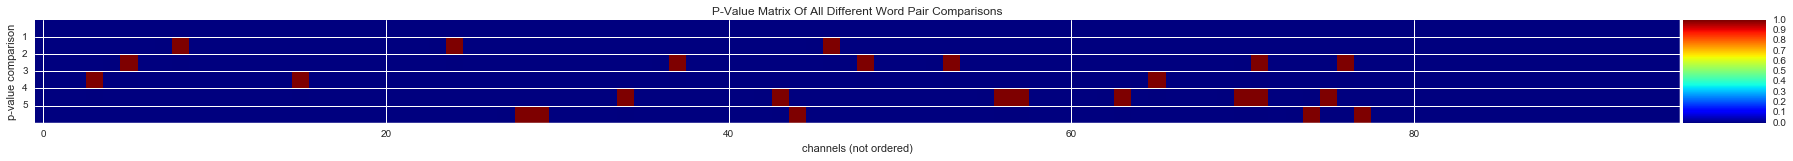

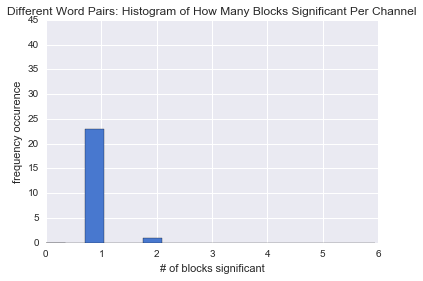

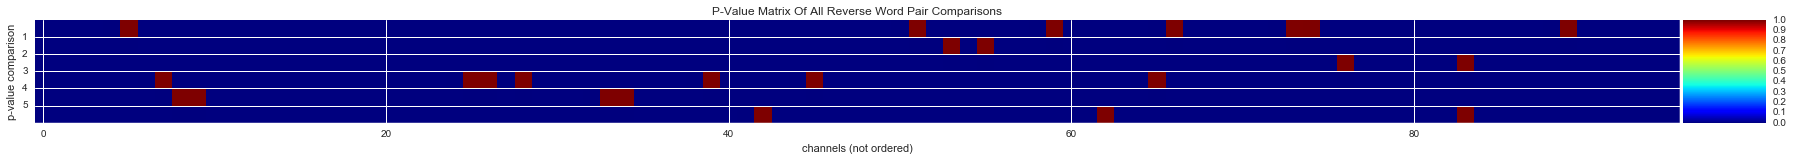

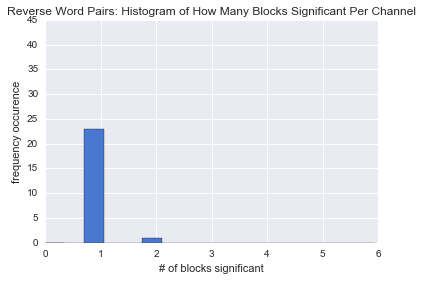

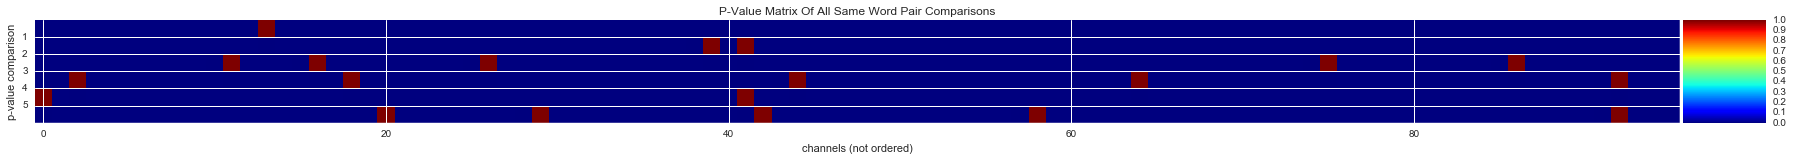

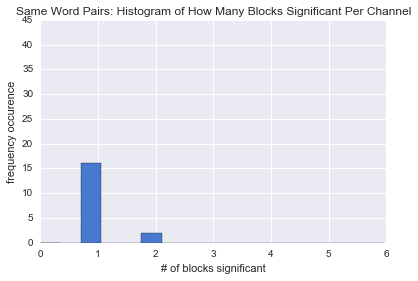

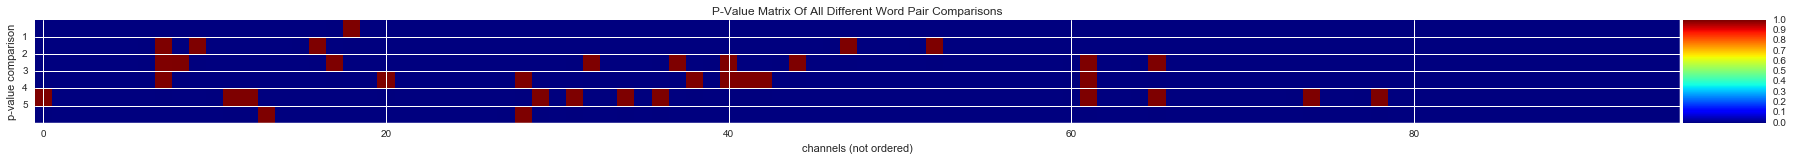

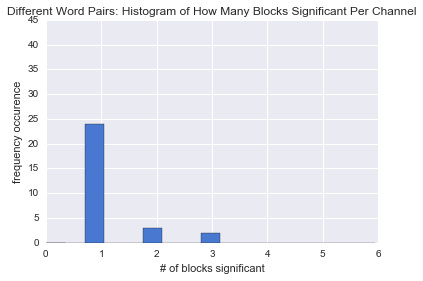

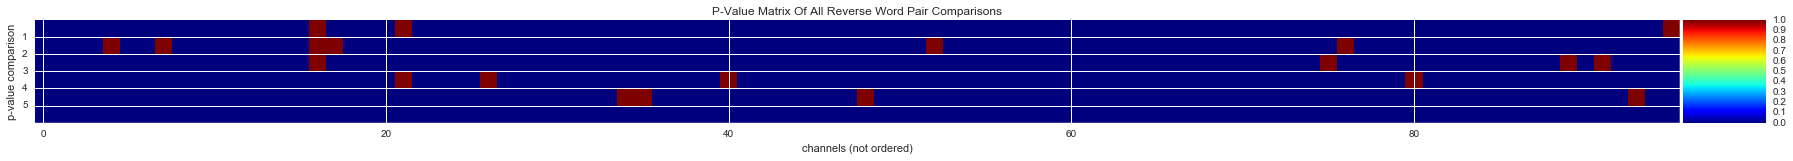

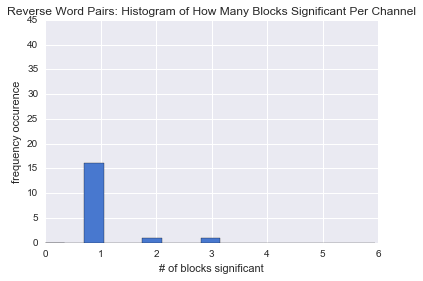

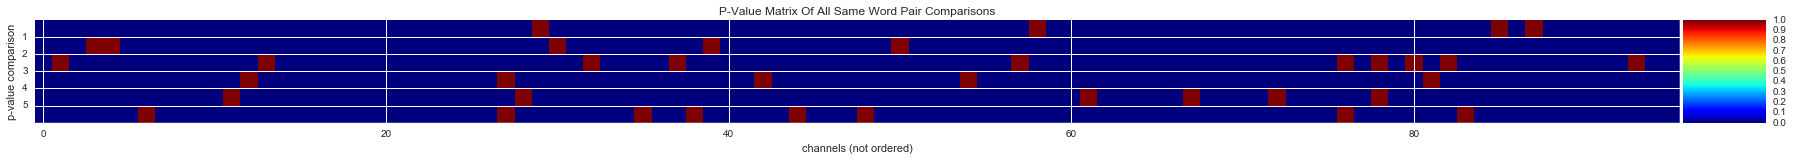

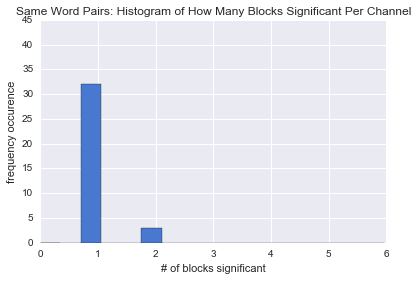

In [22]:
data = np.load('../notebooks/within_low_freq_channel_analysis.npy').item()
print data.keys()

binwidth = 0.35
for session in data.keys():
    session_pval_same_mat = data[session]['same']
    session_pval_diff_mat = data[session]['diff']
    session_pval_reverse_mat = data[session]['reverse']
    
    print "\n On session: ", session
    ### Different word pairs
    buff = session_pval_diff_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0

    fig=plt.figure(figsize=(25,60))
    ax=plt.gca()
    im = plt.imshow(buff, interpolation='none', cmap='jet')
    plt.xlabel('channels (not ordered)')
    plt.ylabel('p-value comparison')
    plt.title('P-Value Matrix Of All Different Word Pair Comparisons')
    plt.yticks(np.arange(0.5,6,1), np.arange(1, 6, 1))
    vmin, vmax = plt.gci().get_clim()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    
    # make histogram
    buff[buff==1] = 0.5
    buff[buff==0] = 1
    buff[buff==0.5] = 0
    hist = np.sum(buff, axis=0)
    print hist.shape
    fig = plt.figure()
    ax=plt.gca()
    plt.hist(hist[hist>0], bins=np.arange(0, 6, binwidth))
    plt.xlabel('# of blocks significant')
    plt.ylabel('frequency occurence')
    plt.title('Different Word Pairs: Histogram of How Many Blocks Significant Per Channel')
    plt.xticks(np.arange(0,7,1), np.arange(0,7,1))
    plt.ylim([0, 45])
    plt.tight_layout()
    print len(buff[buff==1])
    
    ### Reverse word pairs
    buff = session_pval_reverse_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0

    fig=plt.figure(figsize=(25,60))
    ax=plt.gca()
    im = plt.imshow(buff, interpolation='none', cmap='jet')
    plt.xlabel('channels (not ordered)')
    plt.ylabel('p-value comparison')
    plt.title('P-Value Matrix Of All Reverse Word Pair Comparisons')
    plt.yticks(np.arange(0.5,6,1), np.arange(1, 6, 1))
    vmin, vmax = plt.gci().get_clim()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    
    # make histogram
    buff[buff==1] = 0.5
    buff[buff==0] = 1
    buff[buff==0.5] = 0
    hist = np.sum(buff, axis=0)
    print hist.shape
    fig = plt.figure()
    ax=plt.gca()
    plt.hist(hist[hist>0], bins=np.arange(0, 6, binwidth))
    plt.xlabel('# of blocks significant')
    plt.ylabel('frequency occurence')
    plt.title('Reverse Word Pairs: Histogram of How Many Blocks Significant Per Channel')
    plt.xticks(np.arange(0,7,1), np.arange(0,7,1))
    plt.ylim([0, 45])
    plt.tight_layout()
    print len(buff[buff==1])
    
    ## Same word pairs
    buff = session_pval_same_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0

    fig=plt.figure(figsize=(25,60))
    ax=plt.gca()
    im = plt.imshow(buff, interpolation='none', cmap='jet')
    plt.xlabel('channels (not ordered)')
    plt.ylabel('p-value comparison')
    plt.title('P-Value Matrix Of All Same Word Pair Comparisons')
    plt.yticks(np.arange(0.5,6,1), np.arange(1, 6, 1))
    vmin, vmax = plt.gci().get_clim()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    

    # make histogram
    buff[buff==1] = 0.5
    buff[buff==0] = 1
    buff[buff==0.5] = 0
    hist = np.sum(buff, axis=0)
    print hist.shape
    fig = plt.figure()
    ax=plt.gca()
    plt.hist(hist[hist>0], bins=np.arange(0, 6, binwidth))
    plt.xlabel('# of blocks significant')
    plt.ylabel('frequency occurence')
    plt.title('Same Word Pairs: Histogram of How Many Blocks Significant Per Channel')
    plt.xticks(np.arange(0,7,1), np.arange(0,7,1))
    plt.ylim([0, 45])
    plt.tight_layout()
    print len(buff[buff==1])

In [8]:
# data = np.load('../notebooks/low_freq_channel_analysis.npy').item()
# print data.keys()

# Discussion Of Lower Frequencies

It is clear that the different word pair comparisons show a lot more significant entries compared to the same and reverse groups. Now, I plan on filtering out my original analysis with these channels and retrying the distance plot comparisons of different groups.

## High Frequencies

Try the same thing on higher frequencies

Analyzing session  session_1
Analyzing block  BLOCK_0
These are the wordpairs in this block:  ['BRICK_CLOCK', 'CLOCK_BRICK', 'GLASS_JUICE', 'JUICE_GLASS']
Analyzing block  BLOCK_1
These are the wordpairs in this block:  ['BRICK_CLOCK', 'CLOCK_BRICK', 'GLASS_PANTS', 'PANTS_GLASS']
Analyzing block  BLOCK_2
These are the wordpairs in this block:  ['BRICK_JUICE', 'GLASS_PANTS', 'JUICE_BRICK', 'PANTS_GLASS']
Analyzing block  BLOCK_3
These are the wordpairs in this block:  ['BRICK_JUICE', 'CLOCK_GLASS', 'GLASS_CLOCK', 'JUICE_BRICK']
Analyzing block  BLOCK_4
These are the wordpairs in this block:  ['BRICK_PANTS', 'CLOCK_GLASS', 'GLASS_CLOCK', 'PANTS_BRICK']
Analyzing block  BLOCK_5
These are the wordpairs in this block:  ['BRICK_PANTS', 'GLASS_JUICE', 'JUICE_GLASS', 'PANTS_BRICK']
old shape of session pval matrix:  (576,)
new shape of session pval matrix:  (6, 96)
Analyzing session  session_2
Analyzing block  BLOCK_0
These are the wordpairs in this block:  ['BRICK_CLOCK', 'CLOCK_BRICK', 'GLAS

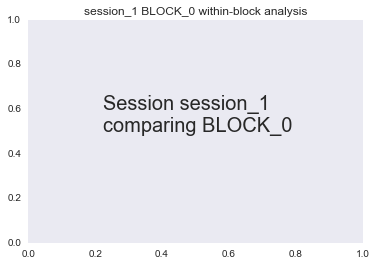

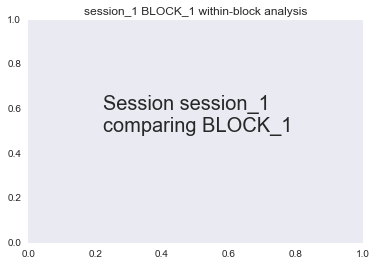

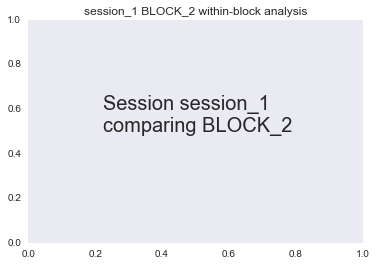

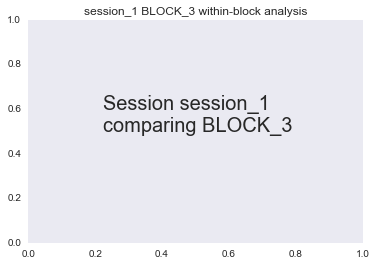

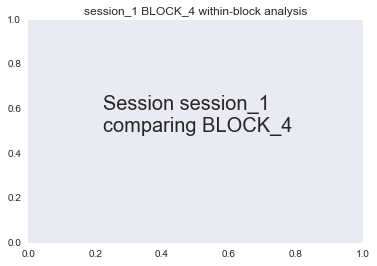

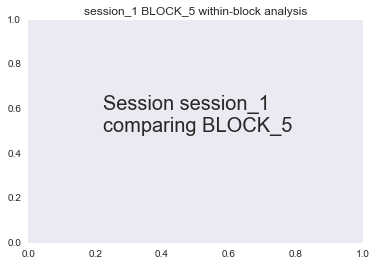

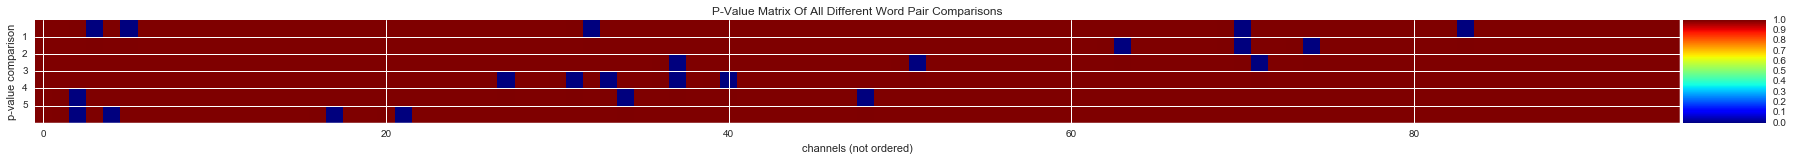

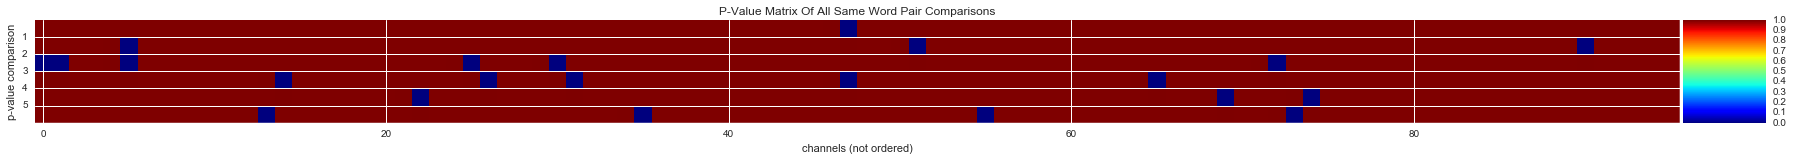

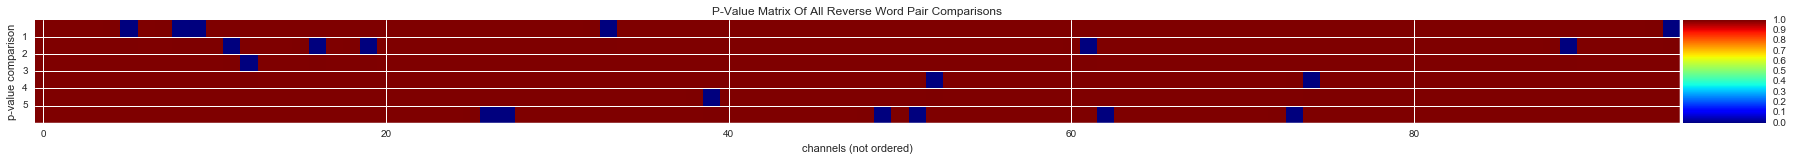

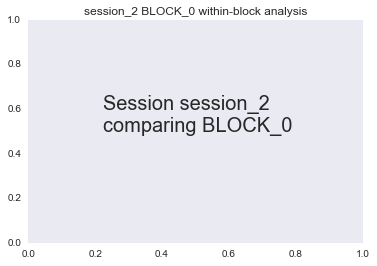

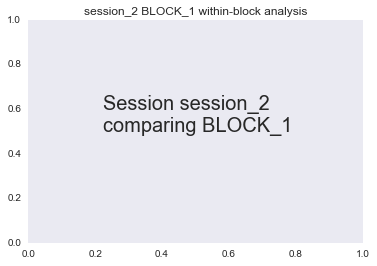

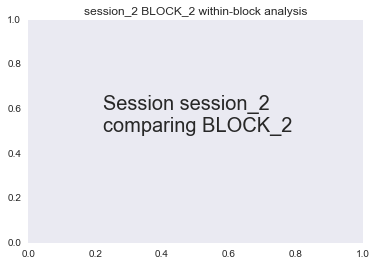

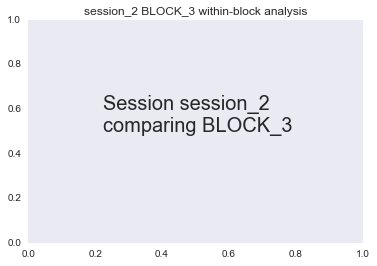

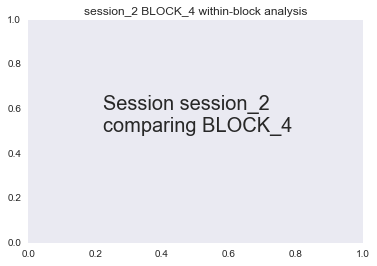

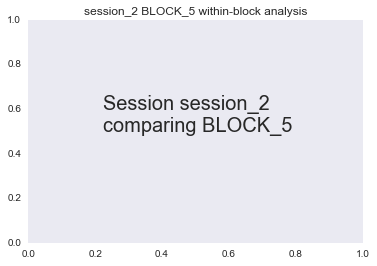

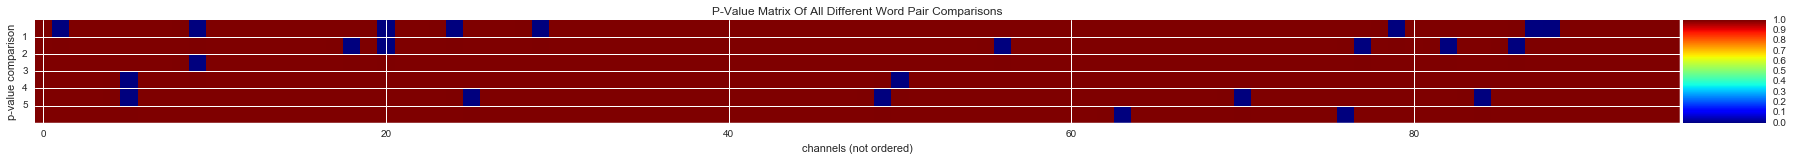

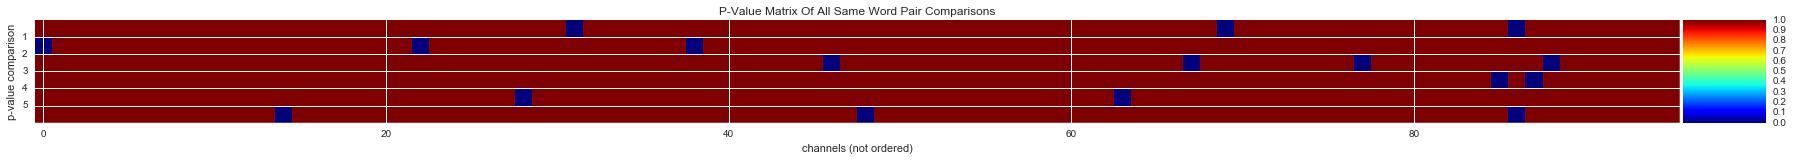

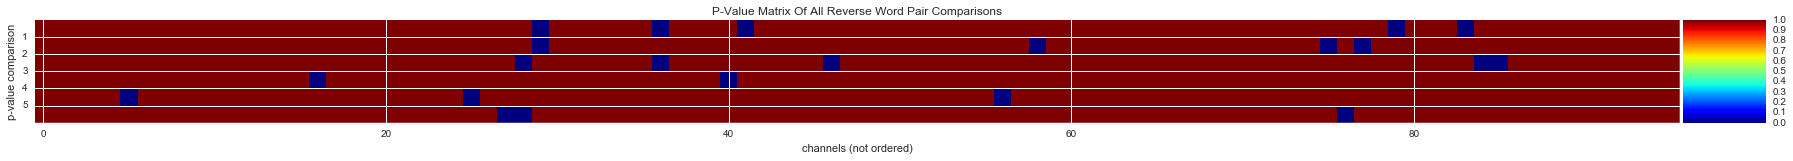

In [9]:
######## Get list of files (.mat) we want to work with ########
filedir = '../condensed_data/blocks/'
sessions = os.listdir(filedir)
sessions = sessions[2:]

session_pval_dict = {}
# loop through each session
for session in sessions:
    print "Analyzing session ", session
    sessiondir = filedir + session
    
    # get all blocks for this session
    blocks = os.listdir(sessiondir)
    
    if len(blocks) != 6: # error check on the directories
        print blocks
        print("Error in the # of blocks. There should be 5.")
        break
    
    session_pval_mat = np.array(())
    session_pval_same_mat = np.array(())
    session_pval_reverse_mat = np.array(())
    # loop through each block one at a time, analyze
    for i in range(0, 6):
        print "Analyzing block ", blocks[i]
        block = blocks[i]
        block_dir = sessiondir + '/' + block
        
        # in each block, get list of word pairs from first and second block
        wordpairs = os.listdir(block_dir)
       
        # within-groups analysis only has: SAME, REVERSE, DIFFERENT
        diff_word_group = []
        reverse_word_group = []
        same_word_group = []
        
        print "These are the wordpairs in this block: ", wordpairs
         
        #### plot meta information about which session and blocks we're analyzing
        fig=plt.figure()
        axes = plt.gca()
        ymin, ymax = axes.get_ylim()
        xmin, xmax = axes.get_xlim()
        plt.text((xmax-xmin)/4.5, (ymax-ymin)/2, r'Session %s %scomparing %s'%(session, '\n',block), fontsize=20)
        plt.title(session + ' ' + block + ' within-block analysis')
        plt.grid(False)
        
        ## 01: Create WordPair Groups
        # create same group pairs
        for idx, pair in enumerate(wordpairs):
            same_word_group.append([pair, pair])
        
        # create reverse, and different groups
        for idx, pairs in enumerate(itertools.combinations(wordpairs,2)):
            if isReverse(pairs[0], pairs[1]):
                reverse_word_group.append([pairs[0], pairs[1]])
            else:
                diff_word_group.append([pairs[0], pairs[1]])
        
        channels = os.listdir(block_dir+'/'+same_word_group[0][0])
        
        session_block_pval_dict = {}
        session_block_pval_mat = np.array(())
        session_block_pval_same_mat = np.array(())
        session_block_pval_reverse_mat = np.array(())
        ## 02: Create feature_dicts from each channel
        for jdx, chan in sorted(enumerate(channels)):
            ### Go through each group and extract the feature data for each wordpair comparison
            same_feature_dict = extractFeaturesForChannel(same_word_group,session,block,block_dir, chan, high_freq_bands)
            reverse_feature_dict = extractFeaturesForChannel(reverse_word_group,session,block,block_dir, chan, high_freq_bands)
            diff_feature_dict = extractFeaturesForChannel(diff_word_group,session,block,block_dir, chan, high_freq_bands)

#             print 'Done Extracting Feature Data Into Dictionaries for channel: ', chan

            same_distances = np.array(())
            reverse_distances = np.array(())
            diff_distances = np.array(())
            ######################################## SAME WORD PAIRS ########################################
            p_val = 0
            anova_list = {}
#             print 'Analyzing same word pairs...'
            for idx, comp in enumerate(same_feature_dict.keys()):
                distance_hist = computePairRepeatedDistances(same_feature_dict[comp][0], same_feature_dict[comp][1])
                distance_hist = 1-distance_hist

                # append all same_group's distance comparisons into 1 vector
                same_distances = np.append(same_distances, distance_hist, axis=0)
                anova_list[str(idx)] = distance_hist
#                 print "Analyzing ", comp

            # perform ANOVA on same groups
#             print anova_list.keys()
            stat, p_val = stats.f_oneway(anova_list['0'], anova_list['1'], anova_list['2'], anova_list['3'])
#             print "Same groups ANOVA has p-val: ", p_val

            ######################################## REVERSED WORD PAIRS ########################################
            stat_pair_list = {}
#             print 'Analyzing reverse word pairs...'
            for idx, comp in enumerate(reverse_feature_dict.keys()):
                distance_hist = 1-computePairDistances(reverse_feature_dict[comp][0], reverse_feature_dict[comp][1])
#                 print "Analyzing ", comp

                stat_pair_list[str(idx)] = distance_hist
                reverse_distances = np.append(reverse_distances, distance_hist)

            # perform Wilcoxon
            stat, p_val = stats.ranksums(stat_pair_list['0'], stat_pair_list['1'])
#             print stat_pair_list.keys()
#             print "Reverse groups Wilcoxon Signed Rank Test has p-val: ", p_val

            ####################################### DIFFERENT WORD PAIRS ########################################
            anova_list = {}
#             print 'Analyzing different word pairs...'
            for idx, comp in enumerate(diff_feature_dict.keys()):
                distance_hist = 1-computePairDistances(diff_feature_dict[comp][0], diff_feature_dict[comp][1])
#                 print "Analyzing ", comp

                anova_list[str(idx)] = distance_hist
                diff_distances = np.append(diff_distances, distance_hist)

            # perform ANOVA on same groups
#             print anova_list.keys()
            stat, p_val = stats.f_oneway(anova_list['0'], anova_list['1'], anova_list['2'], anova_list['3'])
#             print "Different groups ANOVA has p-val: ", p_val
        
#             print same_distances.shape
#             print reverse_distances.shape
#             print diff_distances.shape
            ##### RUN STATS COMPARISONS ON SAME VS. REVERSE, SAME VS. DIFF, 
            random_subset = np.random.choice(range(same_distances.shape[0]), size=len(same_distances)/2, replace=False)
            random_subset2 = list(set(np.arange(0, len(same_distances))) - set(random_subset))
            same_X = same_distances[random_subset]
            same_Y = same_distances[random_subset2]
#             print random_subset2

            stat, same_p_val = stats.ks_2samp(same_X, same_Y)
            stat, reverse_p_val = stats.ks_2samp(same_distances, reverse_distances)
            stat, diff_p_val = stats.ks_2samp(same_distances, diff_distances)
            session_block_pval_mat = np.append(session_block_pval_mat, diff_p_val)
            session_block_pval_same_mat = np.append(session_block_pval_same_mat, same_p_val)
            session_block_pval_reverse_mat = np.append(session_block_pval_reverse_mat, reverse_p_val)
            
#             session_block_pval_dict[chan] = np.array(())
#             session_block_pval_dict[chan] = np.append(session_block_pval_dict[chan], np.array((same_p_val, reverse_p_val, diff_p_val)))
#             session_block_pval_mat = np.concatenate((session_block_pval_mat, np.array((same_p_val, reverse_p_val, diff_p_val))))
            
#         print session_block_pval_mat.shape
        session_block_pval_mat = np.reshape(session_block_pval_mat, (session_block_pval_mat.shape[0]/96, 96))
        session_block_pval_same_mat = np.reshape(session_block_pval_same_mat, (session_block_pval_same_mat.shape[0]/96, 96))
        session_block_pval_reverse_mat = np.reshape(session_block_pval_reverse_mat, (session_block_pval_reverse_mat.shape[0]/96, 96))
#         print session_block_pval_mat.shape
        
        ## append block p-values to session level p-value matrix
        session_pval_mat = np.append(session_pval_mat, session_block_pval_mat)
        session_pval_same_mat = np.append(session_pval_same_mat, session_block_pval_same_mat)
        session_pval_reverse_mat = np.append(session_pval_reverse_mat, session_block_pval_reverse_mat)
        
#         break # look at 1 block
    print 'old shape of session pval matrix: ', session_pval_mat.shape
    session_pval_mat = np.reshape(session_pval_mat, (session_pval_mat.shape[0]/96, 96))
    session_pval_same_mat = np.reshape(session_pval_same_mat, (session_pval_same_mat.shape[0]/96, 96))
    session_pval_reverse_mat = np.reshape(session_pval_reverse_mat, (session_pval_reverse_mat.shape[0]/96, 96))
    print 'new shape of session pval matrix: ', session_pval_mat.shape

    buff = session_pval_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0

    fig=plt.figure(figsize=(25,60))
    ax=plt.gca()
    im = plt.imshow(buff, interpolation='none', cmap='jet')
    plt.xlabel('channels (not ordered)')
    plt.ylabel('p-value comparison')
    plt.title('P-Value Matrix Of All Different Word Pair Comparisons')
    plt.yticks(np.arange(0.5,6,1), np.arange(1, 6, 1))
    vmin, vmax = plt.gci().get_clim()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    
    buff = session_pval_same_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0

    fig=plt.figure(figsize=(25,60))
    ax=plt.gca()
    im = plt.imshow(buff, interpolation='none', cmap='jet')
    plt.xlabel('channels (not ordered)')
    plt.ylabel('p-value comparison')
    plt.title('P-Value Matrix Of All Same Word Pair Comparisons')
    plt.yticks(np.arange(0.5,6,1), np.arange(1, 6, 1))
    vmin, vmax = plt.gci().get_clim()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    
    buff = session_pval_reverse_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0

    fig=plt.figure(figsize=(25,60))
    ax=plt.gca()
    im = plt.imshow(buff, interpolation='none', cmap='jet')
    plt.xlabel('channels (not ordered)')
    plt.ylabel('p-value comparison')
    plt.title('P-Value Matrix Of All Reverse Word Pair Comparisons')
    plt.yticks(np.arange(0.5,6,1), np.arange(1, 6, 1))
    vmin, vmax = plt.gci().get_clim()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    
    session_pval_dict[session] = {}
    session_pval_dict[session]['same'] = session_pval_same_mat
    session_pval_dict[session]['reverse'] = session_pval_reverse_mat
    session_pval_dict[session]['diff'] = session_pval_mat
    
#     break # look at 1 session

In [10]:
high_freq_channel_data = session_pval_dict
print high_freq_channel_data.keys()
np.save('../notebooks/high_freq_channel_analysis.npy', high_freq_channel_data)

['session_1', 'session_2']


['session_1', 'session_2']

 On session:  session_1
(96,)
23
(96,)
20
(96,)
22

 On session:  session_2
(96,)
24
(96,)
22
(96,)
17


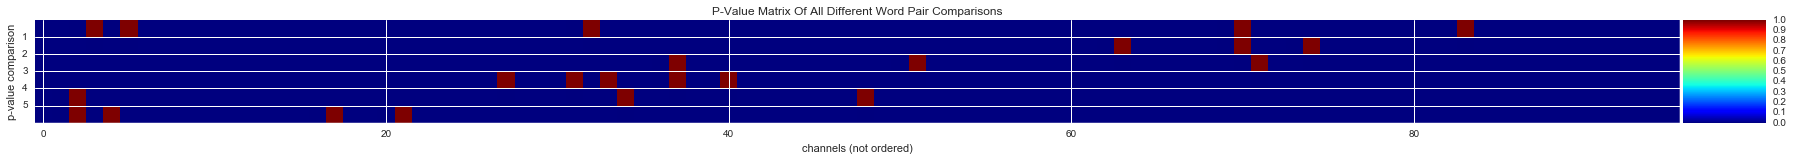

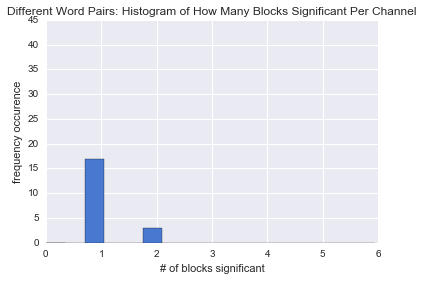

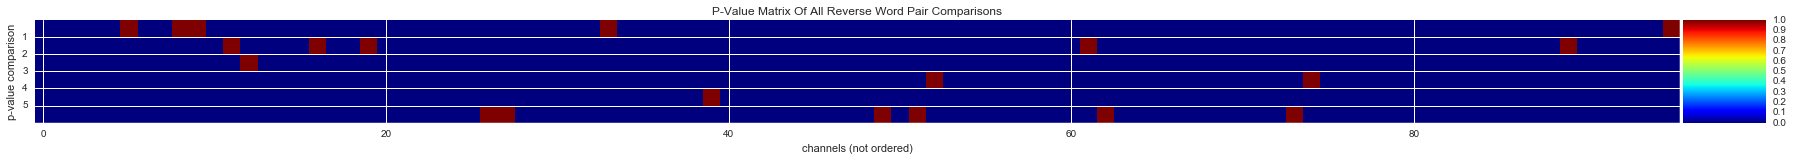

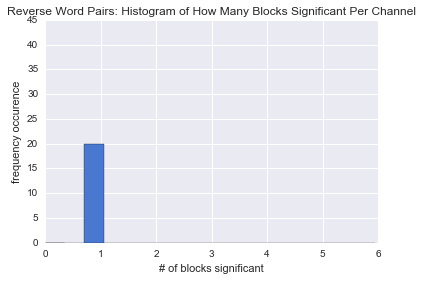

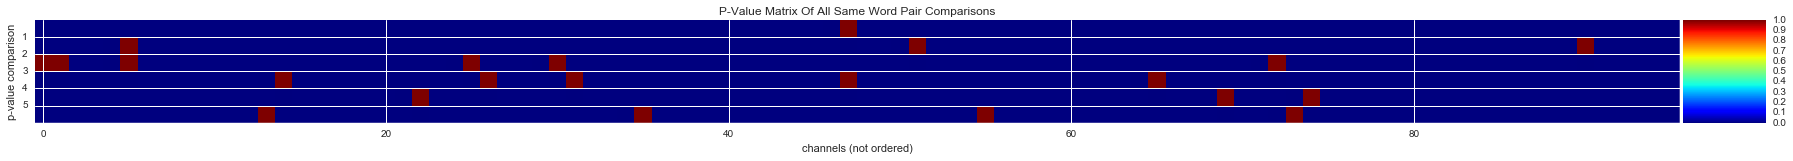

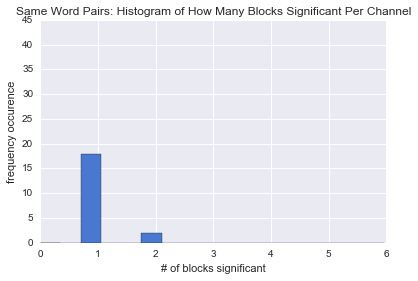

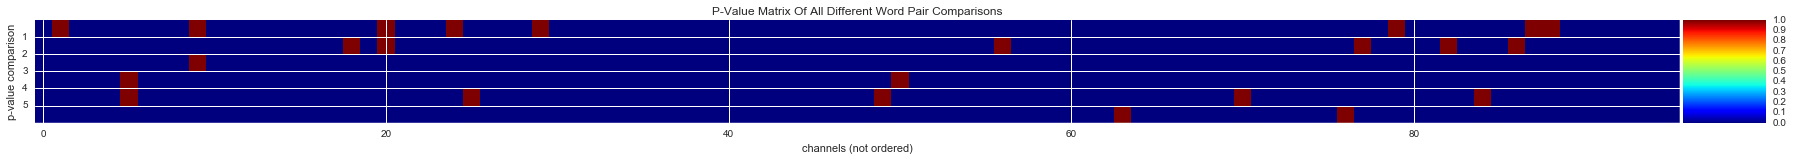

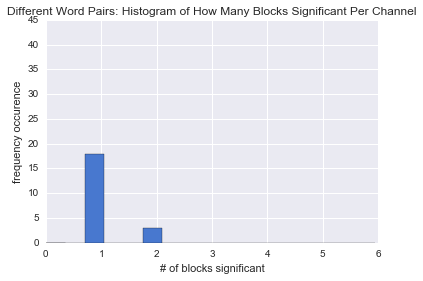

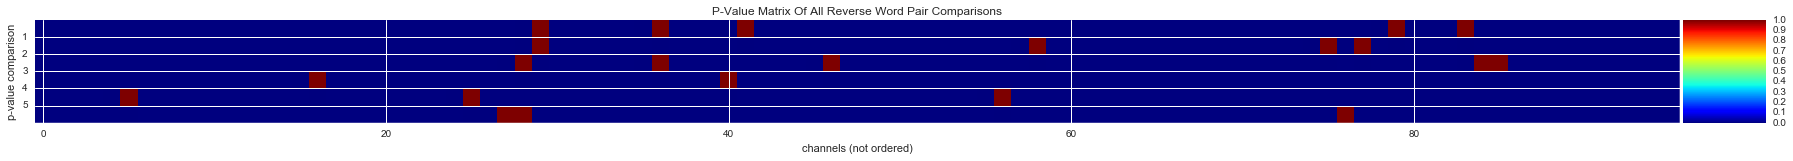

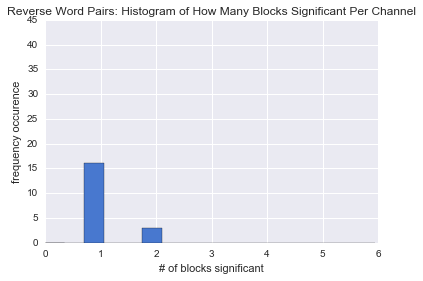

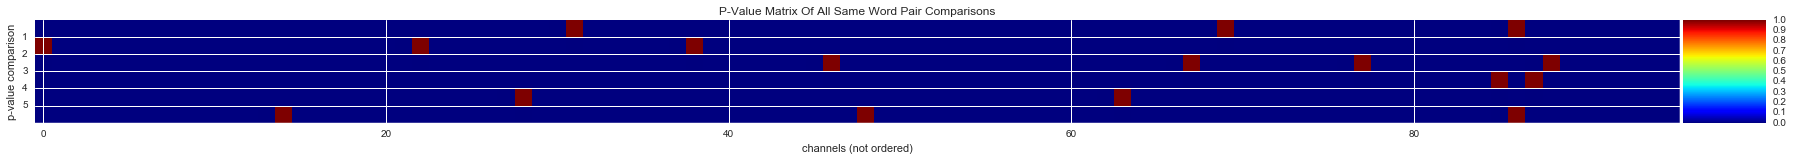

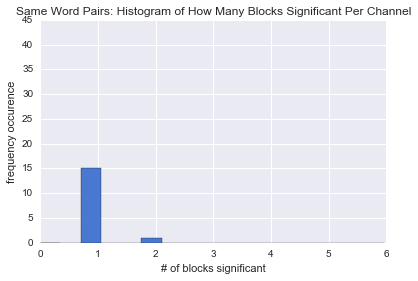

In [5]:
data = np.load('../notebooks/high_freq_channel_analysis.npy').item()
print data.keys()

binwidth = 0.35
for session in data.keys():
    session_pval_same_mat = data[session]['same']
    session_pval_diff_mat = data[session]['diff']
    session_pval_reverse_mat = data[session]['reverse']
    
    print "\n On session: ", session
    ### Different word pairs
    buff = session_pval_diff_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0

    fig=plt.figure(figsize=(25,60))
    ax=plt.gca()
    im = plt.imshow(buff, interpolation='none', cmap='jet')
    plt.xlabel('channels (not ordered)')
    plt.ylabel('p-value comparison')
    plt.title('P-Value Matrix Of All Different Word Pair Comparisons')
    plt.yticks(np.arange(0.5,6,1), np.arange(1, 6, 1))
    vmin, vmax = plt.gci().get_clim()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    
    # make histogram
    buff[buff==1] = 0.5
    buff[buff==0] = 1
    buff[buff==0.5] = 0
    hist = np.sum(buff, axis=0)
    print hist.shape
    fig = plt.figure()
    ax=plt.gca()
    plt.hist(hist[hist>0], bins=np.arange(0, 6, binwidth))
    plt.xlabel('# of blocks significant')
    plt.ylabel('frequency occurence')
    plt.title('Different Word Pairs: Histogram of How Many Blocks Significant Per Channel')
    plt.xticks(np.arange(0,7,1), np.arange(0,7,1))
    plt.ylim([0, 45])
    plt.tight_layout()
    print len(buff[buff==1])
    
    ### Reverse word pairs
    buff = session_pval_reverse_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0

    fig=plt.figure(figsize=(25,60))
    ax=plt.gca()
    im = plt.imshow(buff, interpolation='none', cmap='jet')
    plt.xlabel('channels (not ordered)')
    plt.ylabel('p-value comparison')
    plt.title('P-Value Matrix Of All Reverse Word Pair Comparisons')
    plt.yticks(np.arange(0.5,6,1), np.arange(1, 6, 1))
    vmin, vmax = plt.gci().get_clim()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    
    # make histogram
    buff[buff==1] = 0.5
    buff[buff==0] = 1
    buff[buff==0.5] = 0
    hist = np.sum(buff, axis=0)
    print hist.shape
    fig = plt.figure()
    ax=plt.gca()
    plt.hist(hist[hist>0], bins=np.arange(0, 6, binwidth))
    plt.xlabel('# of blocks significant')
    plt.ylabel('frequency occurence')
    plt.title('Reverse Word Pairs: Histogram of How Many Blocks Significant Per Channel')
    plt.xticks(np.arange(0,7,1), np.arange(0,7,1))
    plt.ylim([0, 45])
    plt.tight_layout()
    print len(buff[buff==1])
    
    ## Same word pairs
    buff = session_pval_same_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0

    fig=plt.figure(figsize=(25,60))
    ax=plt.gca()
    im = plt.imshow(buff, interpolation='none', cmap='jet')
    plt.xlabel('channels (not ordered)')
    plt.ylabel('p-value comparison')
    plt.title('P-Value Matrix Of All Same Word Pair Comparisons')
    plt.yticks(np.arange(0.5,6,1), np.arange(1, 6, 1))
    vmin, vmax = plt.gci().get_clim()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    

    # make histogram
    buff[buff==1] = 0.5
    buff[buff==0] = 1
    buff[buff==0.5] = 0
    hist = np.sum(buff, axis=0)
    print hist.shape
    fig = plt.figure()
    ax=plt.gca()
    plt.hist(hist[hist>0], bins=np.arange(0, 6, binwidth))
    plt.xlabel('# of blocks significant')
    plt.ylabel('frequency occurence')
    plt.title('Same Word Pairs: Histogram of How Many Blocks Significant Per Channel')
    plt.xticks(np.arange(0,7,1), np.arange(0,7,1))
    plt.ylim([0, 45])
    plt.tight_layout()
    print len(buff[buff==1])

# Discussion i)
For both lower and higher frequencies, we see a significant number of channels that help differentiate different word groups and reverse word groups vs. the same word groups.

Next, for both low and high frequencies, I want to visualize how many blocks are significant for each channel. Then I can make an educated cutoff of which channels I want to include in my distance analysis.

Then I can analyze those distances and reperform a classification analysis.

1. Plot histograms of # significant blocks per channel. (total n=96)
2. Set a threshold to pick a few channels of significance.
3. Reperform distance analysis with histograms of distance distributions
4. Reperform classification analysis

In [12]:
import pandas as pd
# from tabulate import tabulate
print 96*6
print (96*6)*0.05

d = {'session one' : pd.Series([115, 68, 27], index=['diff', 'reverse', 'same']),
     'session two' : pd.Series([104, 65, 40], index=['diff', 'reverse', 'same'])}

df = pd.DataFrame(d)
# print tabulate(df, headers='keys', tablefmt='psql')
print df


576
28.8
         session one  session two
diff             115          104
reverse           68           65
same              27           40


['session_1', 'session_2']

 On session:  session_1
(96,)
23
(96,)
20
(96,)
22

 On session:  session_2
(96,)
24
(96,)
22
(96,)
17


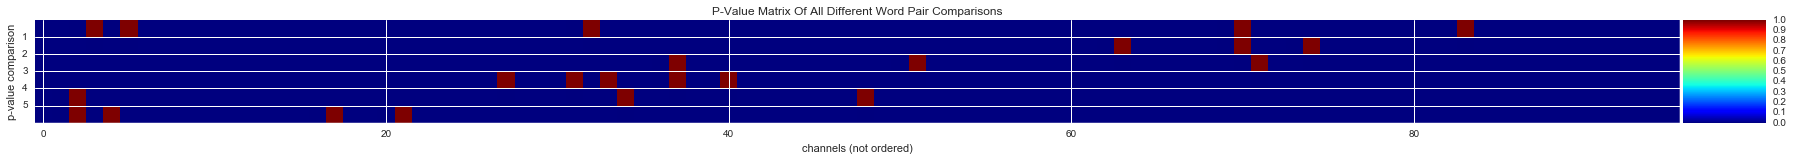

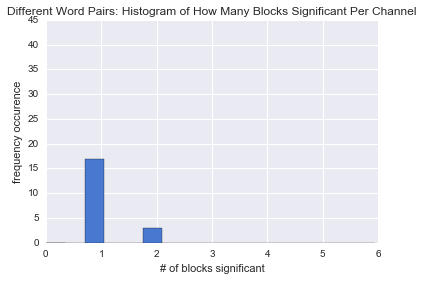

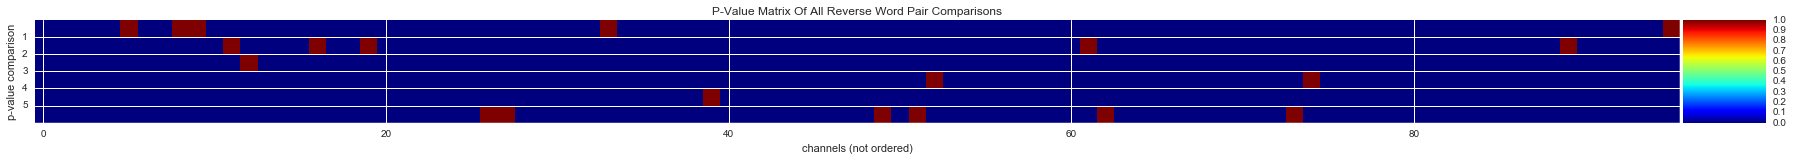

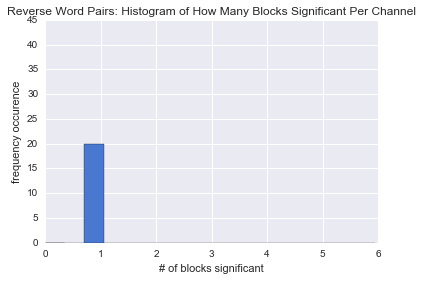

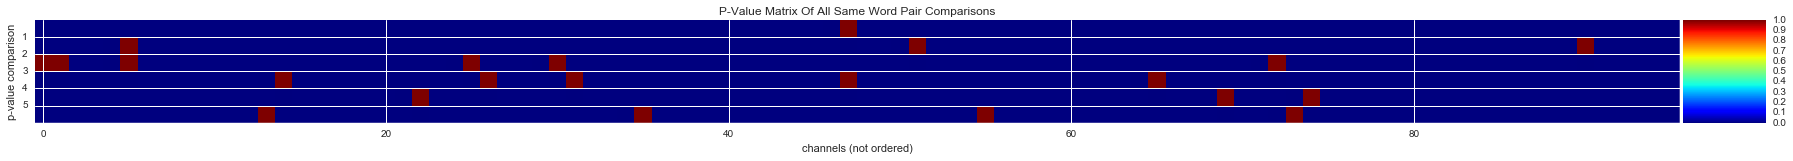

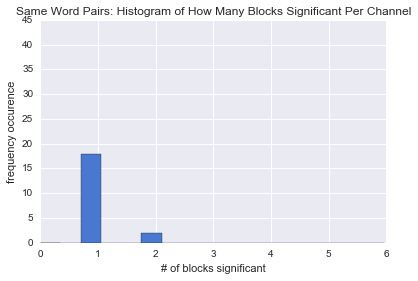

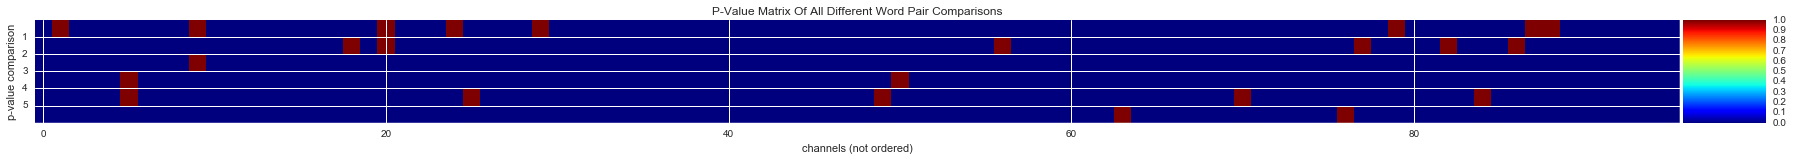

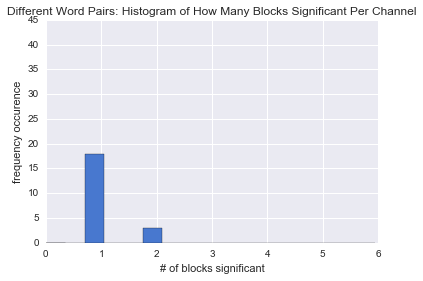

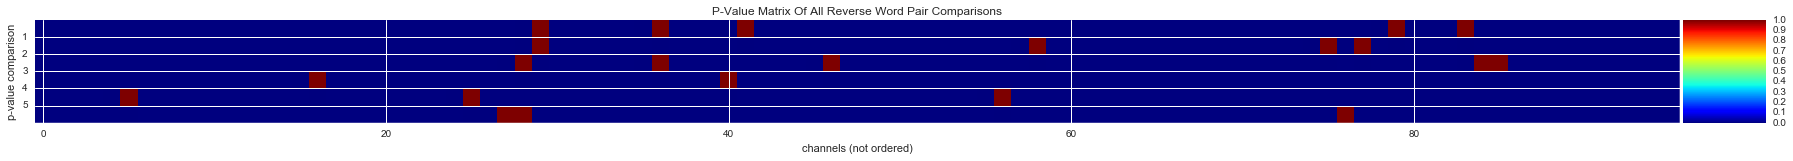

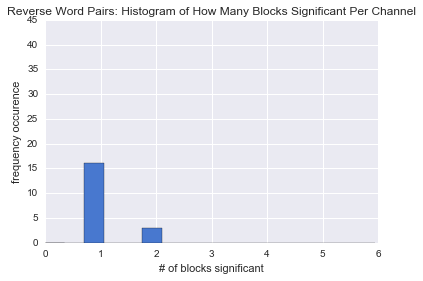

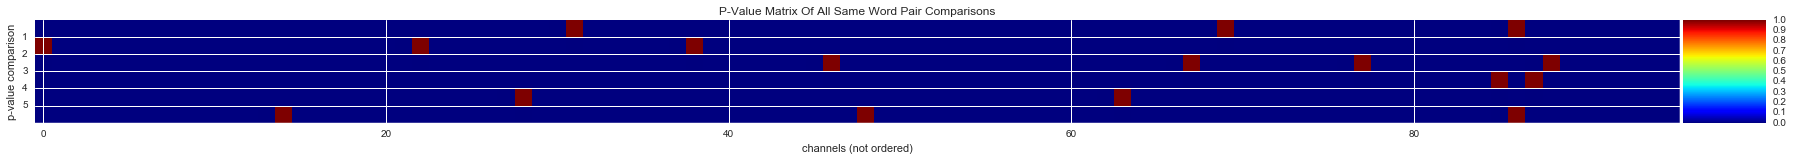

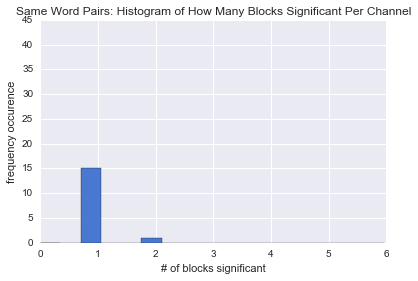

In [13]:
data = np.load('../notebooks/high_freq_channel_analysis.npy').item()
print data.keys()

binwidth = 0.35
for session in data.keys():
    session_pval_same_mat = data[session]['same']
    session_pval_diff_mat = data[session]['diff']
    session_pval_reverse_mat = data[session]['reverse']
    
    print "\n On session: ", session
    ### Different word pairs
    buff = session_pval_diff_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0

    fig=plt.figure(figsize=(25,60))
    ax=plt.gca()
    im = plt.imshow(buff, interpolation='none', cmap='jet')
    plt.xlabel('channels (not ordered)')
    plt.ylabel('p-value comparison')
    plt.title('P-Value Matrix Of All Different Word Pair Comparisons')
    plt.yticks(np.arange(0.5,6,1), np.arange(1, 6, 1))
    vmin, vmax = plt.gci().get_clim()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    
    # make histogram
    buff[buff==1] = 0.5
    buff[buff==0] = 1
    buff[buff==0.5] = 0
    hist = np.sum(buff, axis=0)
    print hist.shape
    fig = plt.figure()
    ax=plt.gca()
    plt.hist(hist[hist>0], bins=np.arange(0, 6, binwidth))
    plt.xlabel('# of blocks significant')
    plt.ylabel('frequency occurence')
    plt.title('Different Word Pairs: Histogram of How Many Blocks Significant Per Channel')
    plt.xticks(np.arange(0,7,1), np.arange(0,7,1))
    plt.ylim([0, 45])
    plt.tight_layout()
    print len(buff[buff==1])
    
    ### Reverse word pairs
    buff = session_pval_reverse_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0

    fig=plt.figure(figsize=(25,60))
    ax=plt.gca()
    im = plt.imshow(buff, interpolation='none', cmap='jet')
    plt.xlabel('channels (not ordered)')
    plt.ylabel('p-value comparison')
    plt.title('P-Value Matrix Of All Reverse Word Pair Comparisons')
    plt.yticks(np.arange(0.5,6,1), np.arange(1, 6, 1))
    vmin, vmax = plt.gci().get_clim()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    
    # make histogram
    buff[buff==1] = 0.5
    buff[buff==0] = 1
    buff[buff==0.5] = 0
    hist = np.sum(buff, axis=0)
    print hist.shape
    fig = plt.figure()
    ax=plt.gca()
    plt.hist(hist[hist>0], bins=np.arange(0, 6, binwidth))
    plt.xlabel('# of blocks significant')
    plt.ylabel('frequency occurence')
    plt.title('Reverse Word Pairs: Histogram of How Many Blocks Significant Per Channel')
    plt.xticks(np.arange(0,7,1), np.arange(0,7,1))
    plt.ylim([0, 45])
    plt.tight_layout()
    print len(buff[buff==1])
    
    ## Same word pairs
    buff = session_pval_same_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0

    fig=plt.figure(figsize=(25,60))
    ax=plt.gca()
    im = plt.imshow(buff, interpolation='none', cmap='jet')
    plt.xlabel('channels (not ordered)')
    plt.ylabel('p-value comparison')
    plt.title('P-Value Matrix Of All Same Word Pair Comparisons')
    plt.yticks(np.arange(0.5,6,1), np.arange(1, 6, 1))
    vmin, vmax = plt.gci().get_clim()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    

    # make histogram
    buff[buff==1] = 0.5
    buff[buff==0] = 1
    buff[buff==0.5] = 0
    hist = np.sum(buff, axis=0)
    print hist.shape
    fig = plt.figure()
    ax=plt.gca()
    plt.hist(hist[hist>0], bins=np.arange(0, 6, binwidth))
    plt.xlabel('# of blocks significant')
    plt.ylabel('frequency occurence')
    plt.title('Same Word Pairs: Histogram of How Many Blocks Significant Per Channel')
    plt.xticks(np.arange(0,7,1), np.arange(0,7,1))
    plt.ylim([0, 45])
    plt.tight_layout()
    print len(buff[buff==1])

In [41]:
import pandas as pd
# from tabulate import tabulate
print 96*6
print (96*6)*0.05

d = {'session one' : pd.Series([105, 64, 20], index=['diff', 'reverse', 'same']),
     'session two' : pd.Series([98, 59, 21], index=['diff', 'reverse', 'same'])}

df = pd.DataFrame(d)
# print tabulate(df, headers='keys', tablefmt='psql')
print df


576
28.8
         session one  session two
diff             105           98
reverse           64           59
same              20           21


In [23]:
######## Get list of files (.mat) we want to work with ########
filedir = '../condensed_data/blocks/'
sessions = os.listdir(filedir)
sessions = sessions[2:]

session_pval_dict = {}
# loop through each session
for session in sessions:
    sessiondir = filedir + session
    
    # get all blocks for this session
    blocks = os.listdir(sessiondir)
    
    # loop through each block one at a time, analyze
    for i in range(0, 1):
        block = blocks[i]
        block_dir = sessiondir + '/' + block
        
        # in each block, get list of word pairs from first and second block
        wordpairs = os.listdir(block_dir)
        channels = os.listdir(block_dir+'/'+wordpairs[0])
    break

chan_order = []
for jdx, chan in sorted(enumerate(channels)):
    chan_order.append(chan)
# print chan_order
chan_order = np.array(chan_order)
print len(chan_order)

96


looking at low frequencies
['session_1', 'session_2']

On session:  session_1
# channels with more then 3 significant blocks:  24
# channels with more then 3 significant blocks:  24
# channels with more then 3 significant blocks:  18

On session:  session_2
# channels with more then 3 significant blocks:  29
# channels with more then 3 significant blocks:  18
# channels with more then 3 significant blocks:  35


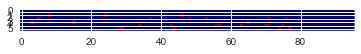

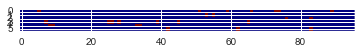

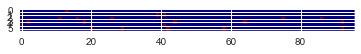

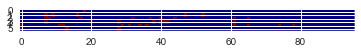

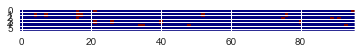

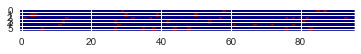

In [24]:
data = np.load('../notebooks/within_low_freq_channel_analysis.npy').item()
print "looking at low frequencies"
print data.keys()

low_session_chans = {}
for session in data.keys():
    low_session_chans[session] = []
    session_pval_same_mat = data[session]['same']
    session_pval_diff_mat = data[session]['diff']
    session_pval_reverse_mat = data[session]['reverse']
    
    print "\nOn session: ", session
    ## DIFFERENT
    buff = session_pval_diff_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0
    # make histogram
    buff[buff==1] = 0.5
    buff[buff==0] = 1
    buff[buff==0.5] = 0
    hist = np.sum(buff, axis=0)
    indices = hist>=1
    print "# channels with more then 3 significant blocks: ", len(chan_order[indices])
    low_session_chans[session].append(chan_order[indices])
    fig = plt.figure()
    plt.imshow(buff, interpolation='none', cmap='jet')
    
    ## REVERSE
    buff = session_pval_reverse_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0    
    # make histogram
    buff[buff==1] = 0.5
    buff[buff==0] = 1
    buff[buff==0.5] = 0
    hist = np.sum(buff, axis=0)
    indices = hist>=1
    print "# channels with more then 3 significant blocks: ", len(chan_order[indices])
    fig = plt.figure()
    plt.imshow(buff, interpolation='none', cmap='jet')
    
    ## Same word pairs
    buff = session_pval_same_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0    
        # make histogram
    buff[buff==1] = 0.5
    buff[buff==0] = 1
    buff[buff==0.5] = 0
    hist = np.sum(buff, axis=0)
    indices = hist>=1
    print "# channels with more then 3 significant blocks: ", len(chan_order[indices])
    fig = plt.figure()
    plt.imshow(buff, interpolation='none', cmap='jet')

# print low_session_chans


### High frequencies

In [17]:
data = np.load('../notebooks/high_freq_channel_analysis.npy').item()
print "looking at high frequencies"
print data.keys()

low_session_chans = {}
for session in data.keys():
    low_session_chans[session] = []
    session_pval_same_mat = data[session]['same']
    session_pval_diff_mat = data[session]['diff']
    session_pval_reverse_mat = data[session]['reverse']
    
    print "\nOn session: ", session
    ## DIFFERENT
    buff = session_pval_diff_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0
    # make histogram
    buff[buff==1] = 0.5
    buff[buff==0] = 1
    buff[buff==0.5] = 0
    hist = np.sum(buff, axis=0)
    indices = hist>=3
    print "# channels with more then 3 significant blocks: ", len(chan_order[indices])
    low_session_chans[session].append(chan_order[indices])
    
    ## REVERSE
    buff = session_pval_reverse_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0    
    # make histogram
    buff[buff==1] = 0.5
    buff[buff==0] = 1
    buff[buff==0.5] = 0
    hist = np.sum(buff, axis=0)
    indices = hist>=3
    print "# channels with more then 3 significant blocks: ", len(chan_order[indices])
    
    ## Same word pairs
    buff = session_pval_same_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0    
        # make histogram
    buff[buff==1] = 0.5
    buff[buff==0] = 1
    buff[buff==0.5] = 0
    hist = np.sum(buff, axis=0)
    indices = hist>=3
    print "# channels with more then 3 significant blocks: ", len(chan_order[indices])

looking at high frequencies
['session_1', 'session_2']

On session:  session_1
# channels with more then 3 significant blocks:  0
# channels with more then 3 significant blocks:  0
# channels with more then 3 significant blocks:  0

On session:  session_2
# channels with more then 3 significant blocks:  0
# channels with more then 3 significant blocks:  0
# channels with more then 3 significant blocks:  0


In [18]:
print "The significant channels for each range of frequencies for different word pairs: "
print "high: ",high_session_chans
print "low: ",low_session_chans

The significant channels for each range of frequencies for different word pairs: 
high: 

NameError: name 'high_session_chans' is not defined

# Within Blocks Distance Analysis
Repeated with only these channels

In [25]:
################################### HYPER-PARAMETERS TO TUNE #######################################################
anova_threshold = 90   # how many channels we want to keep
distances = Distance.cosine # define distance metric to use
num_time_windows = 15
low_freq_bands = [0, 1, 2]
high_freq_bands = [3, 4, 5, 6]
freq_bands = np.arange(0,7,1)

np.random.seed(123456789)  # for reproducibility, set random seed

freq_labels = ['delta', 'theta', 'alpha', 'beta', 'low gamma', 'high gamma', 'HFO']
# print freq_bands
# print [freq_labels[i] for i in freq_bands]

print 'low bands: ', [freq_labels[i] for i in low_freq_bands]
print 'high bands: ', [freq_labels[i] for i in high_freq_bands]
print "The length of the feature vector for each channel will be: ", num_time_windows*len(freq_bands), \
            ' total=', 96*num_time_windows*len(freq_bands)

low bands:  ['delta', 'theta', 'alpha']
high bands:  ['beta', 'low gamma', 'high gamma', 'HFO']
The length of the feature vector for each channel will be:  105  total= 10080


In [34]:
def extractFeaturesForChannel(wordgroup, session, block, block_dir, channels, freq_bands):
    PairFeatureDict = {}
    for idx, pairs in enumerate(wordgroup):
        # load in data
        first_wordpair_dir = block_dir + '/' + pairs[0]
        second_wordpair_dir = block_dir + '/' + pairs[1]

        # initialize np arrays for holding feature vectors for each event
        first_pair_features = []
        second_pair_features = []

        for jdx, chans in sorted(enumerate(channels)):
            # Each wordpair's fullfile dir path
            first_chan_file = first_wordpair_dir + '/' + chans
            second_chan_file = second_wordpair_dir + '/' + chans

            ## 0: load in data
            data_first = scipy.io.loadmat(first_chan_file)
            data_first = data_first['data']
            data_second = scipy.io.loadmat(second_chan_file)
            data_second = data_second['data']

            ## 01: get the time point for probeword on
            first_timeZero = data_first['timeZero'][0][0][0]
            second_timeZero = data_second['timeZero'][0][0][0]

            ## 02: get the time point of vocalization
            first_vocalization = data_first['vocalization'][0][0][0]
            second_vocalization = data_second['vocalization'][0][0][0]

            ## 03: Get Power Matrix
            first_matrix = data_first['powerMatZ'][0][0]
            second_matrix = data_second['powerMatZ'][0][0]
            first_matrix = first_matrix[:,freq_bands,:]
            second_matrix = second_matrix[:,freq_bands,:]

            ### 1: get only the time point before vocalization
            first_mean = []
            second_mean = []
            for i in range(0, len(first_vocalization)):
                # either go from timezero -> vocalization, or some other timewindow
#                 first_mean.append(np.ndarray.flatten(first_matrix[i,:,first_vocalization[i]-num_time_windows:first_vocalization[i]-1]))

                first_mean.append(np.ndarray.flatten(np.mean(first_matrix[i,:,first_vocalization[i]-num_time_windows:first_vocalization[i]-1], axis=1)))

            for i in range(0, len(second_vocalization)):
#                 second_mean.append(np.ndarray.flatten(second_matrix[i,:,second_vocalization[i]-num_time_windows:second_vocalization[i]-1]))

                second_mean.append(np.ndarray.flatten(np.mean(second_matrix[i,:,second_vocalization[i]-num_time_windows:second_vocalization[i]-1], axis=1)))

                
#             print np.array(first_mean).shape
#             print np.array(second_mean).shape
            # create feature vector for each event
            if jdx == 0:
                first_pair_features.append(first_mean)
                second_pair_features.append(second_mean)
                first_pair_features = np.squeeze(np.array(first_pair_features))
                second_pair_features = np.squeeze(np.array(second_pair_features))
            else:
                first_pair_features = np.concatenate((first_pair_features, first_mean), axis=1)
                second_pair_features = np.concatenate((second_pair_features, second_mean), axis=1)
        
#         print first_pair_features.shape
#         print second_pair_features.shape
        # end of loop through channels

        # add to overall dictionary for each comparison word for return statement at end
        pairName = pairs[0] + 'vs' + pairs[1]
        PairFeatureDict[pairName] = []
        PairFeatureDict[pairName].append(first_pair_features)
        PairFeatureDict[pairName].append(second_pair_features)
        
    return PairFeatureDict

# Compute all pairwise distances between first_mat to second_mat
def computePairDistances(first_mat, second_mat):
    distance_list = []
    for idx in range(0, first_mat.shape[0]):
        distance_list.append([distances(x, first_mat[idx,:]) for x in second_mat])
    distance_list = np.ndarray.flatten(np.array(distance_list))
    return distance_list  

def isReverse(pair1, pair2):
    pair1split = pair1.split('_')
    pair2split = pair2.split('_')
    if pair1split[0] == pair2split[1] and pair1split[1] == pair2split[0]:
        return True
    else:
        return False

def groupAllDistances(wordpair_dict):
    distances = np.array(())
    for idx, comp in enumerate(wordpair_dict.keys()):
        # get cosine similarity between two comparisons of words
        distance_hist = computePairDistances(wordpair_dict[comp][0], wordpair_dict[comp][1])
        distance_hist = 1-distance_hist[distance_hist > 0] 
        
        distances = np.append(distances, distance_hist)
    return distances

def groupAllRepeatedDistances(wordpair_dict):
    distances = np.array(())
    for idx, comp in enumerate(wordpair_dict.keys()):
        # get cosine similarity between two comparisons of words
        distance_hist = computePairRepeatedDistances(wordpair_dict[comp][0], wordpair_dict[comp][1])
        distance_hist = 1-distance_hist
        
        distances = np.append(distances, distance_hist)
    return distances

def plotAllHist(wordpair_dict):
    fig = plt.figure(figsize=(8,8))
    for idx, comp in enumerate(wordpair_dict.keys()):
        # get cosine similarity between two comparisons of words
        distance_hist = computePairDistances(wordpair_dict[comp][0], wordpair_dict[comp][1])
        distance_hist = 1-distance_hist[distance_hist > 0] 

        ## Do histogram for same word pairs' distance
        sub = plt.subplot(len(wordpair_dict.keys()), 1, idx+1)
        ax = plt.gca()
        ax.grid(False)
        plt.hist(distance_hist, color='k', lw=3)
        plt.xlabel('Cosine Similarity n='+str(len(distance_hist)))
        plt.ylabel('Frequency Count')
        plt.title('Within-block airwise distances for ' + comp + ' in ' + session + ' with ' + block)
        plt.xlim([-1,1])
        plt.legend(r'n= %s'%(str(len(distance_hist))))
    plt.tight_layout()

In [35]:
print low_session_chans[session][0]
print len(low_session_chans[session][0])

['13_G13-global_groupSessionBlockData.mat'
 '15_G15-global_groupSessionBlockData.mat'
 '18_G18-global_groupSessionBlockData.mat'
 '24_G24-global_groupSessionBlockData.mat'
 '32_G32-global_groupSessionBlockData.mat'
 '36_TT4-global_groupSessionBlockData.mat'
 '37_TT5-global_groupSessionBlockData.mat'
 '41_OF3-global_groupSessionBlockData.mat'
 '44_AST2-global_groupSessionBlockData.mat'
 '4_G4-global_groupSessionBlockData.mat'
 '50_MST4-global_groupSessionBlockData.mat'
 '52_PST2-global_groupSessionBlockData.mat'
 '54_PST4-global_groupSessionBlockData.mat'
 '59_IO5-global_groupSessionBlockData.mat'
 '61_MO1-global_groupSessionBlockData.mat'
 '62_MO2-global_groupSessionBlockData.mat'
 '68_SO2-global_groupSessionBlockData.mat'
 '6_G6-global_groupSessionBlockData.mat'
 '74_PP2-global_groupSessionBlockData.mat'
 '75_PP3-global_groupSessionBlockData.mat'
 '78_PP6-global_groupSessionBlockData.mat'
 '79_PP7-global_groupSessionBlockData.mat'
 '7_G7-global_groupSessionBlockData.mat'
 '80_PP8-glob

Analyzing session  session_1
Finished Extracting.
760
800
1600
On block:  BLOCK_0
Same avg +/- std: 0.138  +/- 0.008
Reverse avg +/- std: 0.132  +/- 0.008
Different avg +/- std: 0.141  +/- 0.006
Same vs. Same comparison: 0.119
Same vs. Reverse Comparison: 0.590
Same vs. Different Comparison: 0.783
Finished Extracting.
650
686
1365
On block:  BLOCK_1
Same avg +/- std: 0.119  +/- 0.009
Reverse avg +/- std: 0.130  +/- 0.008
Different avg +/- std: 0.126  +/- 0.006
Same vs. Same comparison: 0.869
Same vs. Reverse Comparison: 0.370
Same vs. Different Comparison: 0.484
Finished Extracting.
741
780
1560
On block:  BLOCK_2
Same avg +/- std: 0.102  +/- 0.008
Reverse avg +/- std: 0.100  +/- 0.007
Different avg +/- std: 0.077  +/- 0.005
Same vs. Same comparison: 0.234
Same vs. Reverse Comparison: 0.799
Same vs. Different Comparison: 0.007
Finished Extracting.
704
740
1482
On block:  BLOCK_3
Same avg +/- std: 0.111  +/- 0.008
Reverse avg +/- std: 0.099  +/- 0.007
Different avg +/- std: 0.103  +/- 0

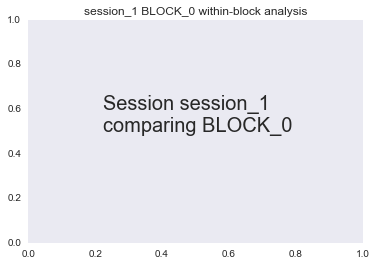

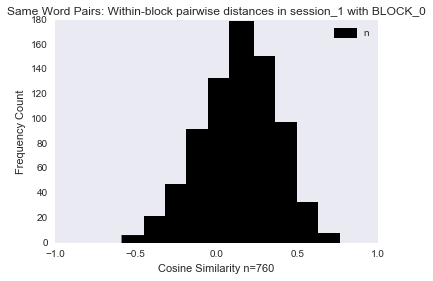

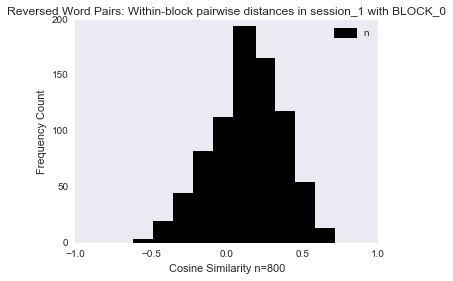

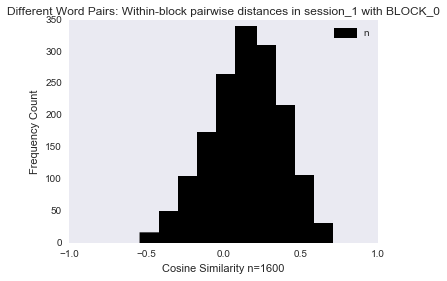

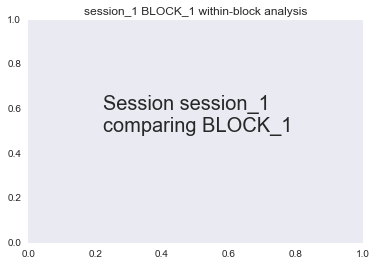

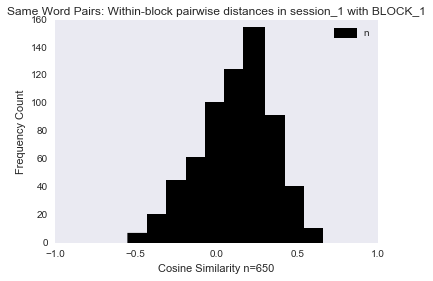

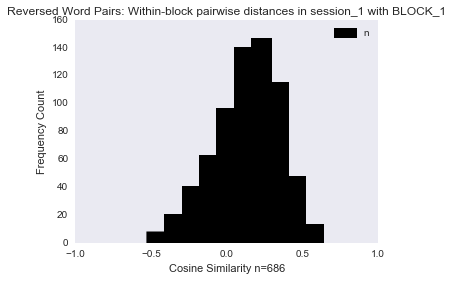

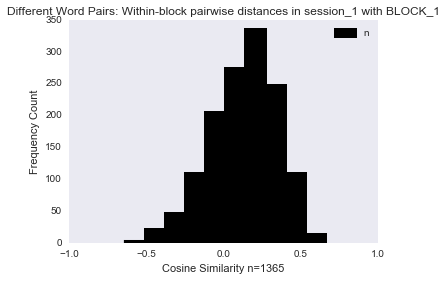

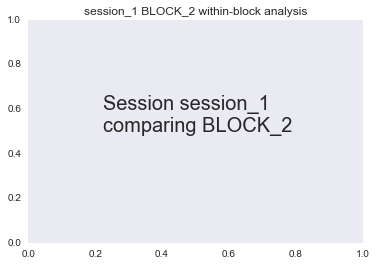

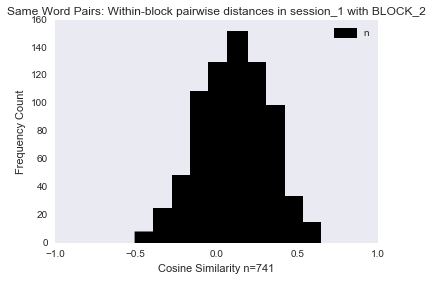

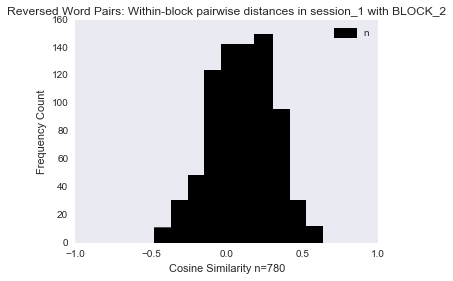

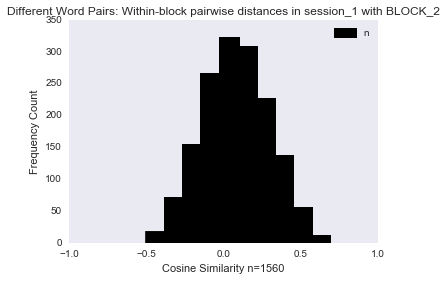

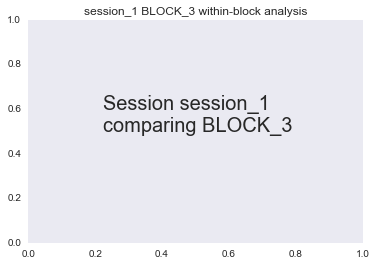

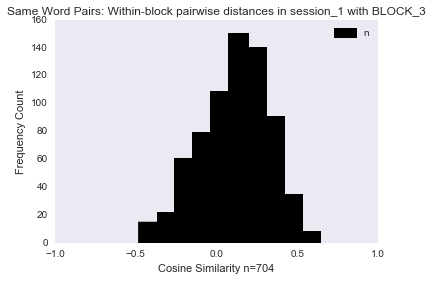

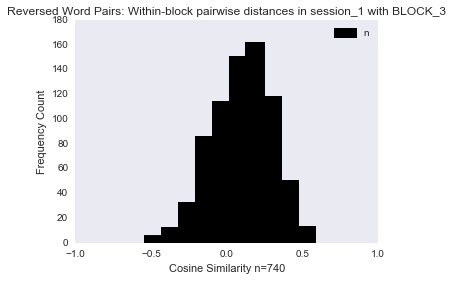

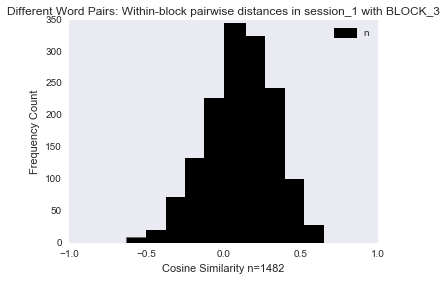

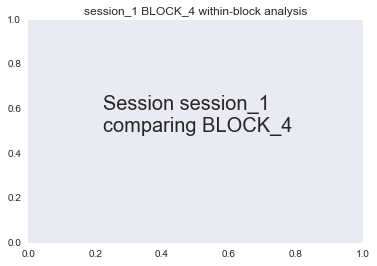

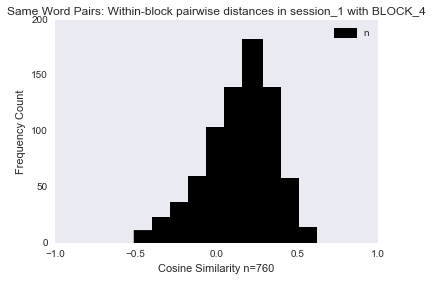

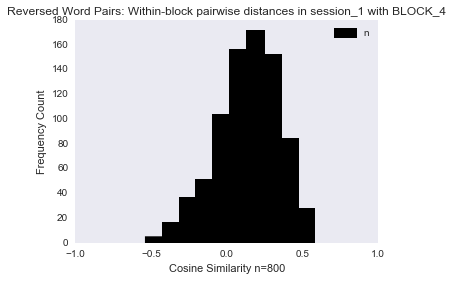

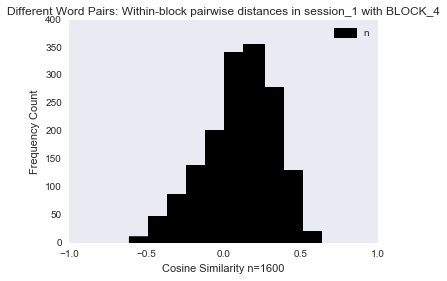

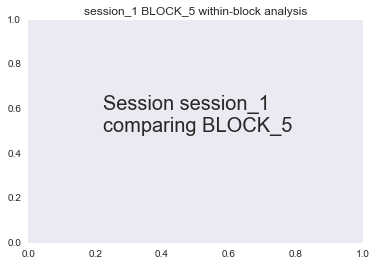

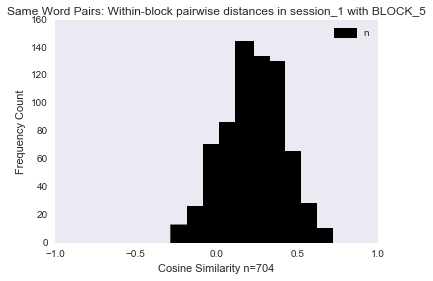

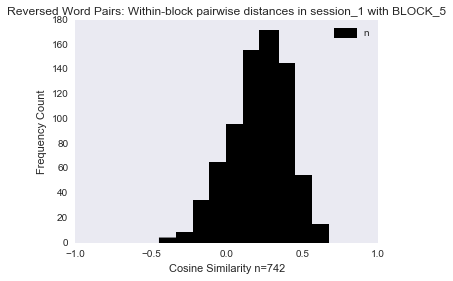

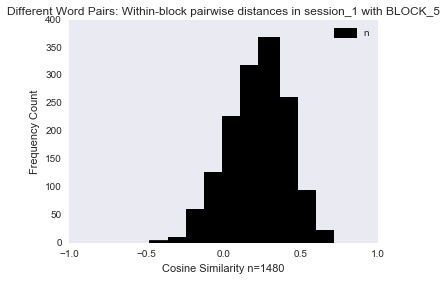

In [38]:
######## Get list of files (.mat) we want to work with ########
filedir = '../condensed_data/blocks/'
sessions = os.listdir(filedir)
sessions = sessions[2:]

# loop through each session
for session in sessions:
    print "Analyzing session ", session
    sessiondir = filedir + session
    
    # get all blocks for this session
    blocks = os.listdir(sessiondir)

    # loop through each block one at a time, analyze
    for i in range(0, 6):
#         print "Analyzing block ", blocks[i]
        block = blocks[i]
        block_dir = sessiondir + '/' + block
        
        # in each block, get list of word pairs from first and second block
        wordpairs = os.listdir(block_dir)
       
        # within-groups analysis only has: SAME, REVERSE, DIFFERENT
        diff_word_group = []
        reverse_word_group = []
        same_word_group = []       
#         print "These are the wordpairs in this block: ", wordpairs
        #### plot meta information about which session and blocks we're analyzing
        fig=plt.figure()
        axes = plt.gca()
        ymin, ymax = axes.get_ylim()
        xmin, xmax = axes.get_xlim()
        plt.text((xmax-xmin)/4.5, (ymax-ymin)/2, r'Session %s %scomparing %s'%(session, '\n',block), fontsize=20)
        plt.title(session + ' ' + block + ' within-block analysis')
        plt.grid(False)
        
        ## 01: Create WordPair Groups
        # create same group pairs
        for idx, pair in enumerate(wordpairs):
            same_word_group.append([pair, pair])
        
        # create reverse, and different groups
        for idx, pairs in enumerate(itertools.combinations(wordpairs,2)):
            if isReverse(pairs[0], pairs[1]):
                reverse_word_group.append([pairs[0], pairs[1]])
            else:
                diff_word_group.append([pairs[0], pairs[1]])
        
        # initialize list of channels we want to look at
#         channels = os.listdir(block_dir+'/'+same_word_group[0][0]) # all channels
#         channels = high_session_chans[session] # high frequency impact channels
        channels = low_session_chans[session][0]
        print "Number of channels used: ", len(channels)
    
        # initialize dictionary and matrices for storing p-values after comparison of word groups
        session_block_pval_dict = {}
        session_block_pval_mat = np.array(())
        session_block_pval_same_mat = np.array(())
        session_block_pval_reverse_mat = np.array(())
        
        ## 02: Create feature_dicts from each channel

        ### Go through each group and extract the feature data for each wordpair comparison
        same_feature_dict = extractFeaturesForChannel(same_word_group,session,block,block_dir, channels, low_freq_bands)
        reverse_feature_dict = extractFeaturesForChannel(reverse_word_group,session,block,block_dir, channels, low_freq_bands)
        diff_feature_dict = extractFeaturesForChannel(diff_word_group,session,block,block_dir, channels, low_freq_bands)

        
        print "Finished Extracting."
        ######################################## SAME WORD PAIRS ########################################
#         plotAllHist(same_feature_dict)
        session_same_distances = groupAllRepeatedDistances(same_feature_dict)
        print len(session_same_distances)
        fig = plt.figure()
        ax = plt.gca()
        ax.grid(False)
        plt.hist(session_same_distances, color='k', lw=3)
        plt.xlabel('Cosine Similarity n='+str(len(session_same_distances)))
        plt.ylabel('Frequency Count')
        plt.title('Same Word Pairs: Within-block pairwise distances in ' + session + ' with ' + block)
        plt.xlim([-1,1])
        plt.legend(r'n= %s'%(str(len(session_same_distances))))
        plt.tight_layout()
    
        ######################################## REVERSED WORD PAIRS ########################################
#         plotAllHist(reverse_feature_dict)
        session_reverse_distances = groupAllDistances(reverse_feature_dict)
        print len(session_reverse_distances)
        fig = plt.figure()
        ax = plt.gca()
        ax.grid(False)
        plt.hist(session_reverse_distances, color='k', lw=3)
        plt.xlabel('Cosine Similarity n='+str(len(session_reverse_distances)))
        plt.ylabel('Frequency Count')
        plt.title('Reversed Word Pairs: Within-block pairwise distances in ' + session + ' with ' + block)
        plt.xlim([-1,1])
        plt.legend(r'n= %s'%(str(len(session_reverse_distances))))
        plt.tight_layout()
        
        ####################################### DIFFERENT WORD PAIRS ########################################        
#         plotAllHist(diff_feature_dict)
        session_diff_distances = groupAllDistances(diff_feature_dict)
        print len(session_diff_distances)
        fig = plt.figure()
        ax = plt.gca()
        ax.grid(False)
        plt.hist(session_diff_distances, color='k', lw=3)
        plt.xlabel('Cosine Similarity n='+str(len(session_diff_distances)))
        plt.ylabel('Frequency Count')
        plt.title('Different Word Pairs: Within-block pairwise distances in ' + session + ' with ' + block)
        plt.xlim([-1,1])
        plt.legend(r'n= %s'%(str(len(session_diff_distances))))
        plt.tight_layout()   
        
        
        ##### RUN STATS COMPARISONS ON SAME VS. REVERSE, SAME VS. DIFF, 
        random_subset = np.random.choice(range(session_same_distances.shape[0]), size=len(session_same_distances)/2, replace=False)
        random_subset2 = list(set(np.arange(0, len(session_same_distances))) - set(random_subset))
        same_X = session_same_distances[random_subset]
        same_Y = session_same_distances[random_subset2]
        
        stat, same_p_val = stats.ks_2samp(same_X, same_Y)
        stat, reverse_p_val = stats.ks_2samp(session_same_distances, session_reverse_distances)
        stat, diff_p_val = stats.ks_2samp(session_same_distances, session_diff_distances)
           
        stat, same_p_val = stats.ttest_ind(same_X, same_Y)
        stat, reverse_p_val = stats.ttest_ind(session_same_distances, session_reverse_distances)
        stat, diff_p_val = stats.ttest_ind(session_same_distances, session_diff_distances)
           
            
#         plotPowerSimulations(same_X, same_Y, 'Same WordPairs')
#         plotPowerSimulations(session_same_distances, session_reverse_distances, 'Reverse WordPairs')
#         plotPowerSimulations(session_same_distances, session_diff_distances, 'Different WordPairs')
            
        print "On block: ", block
        print "Same avg +/- std: %0.3f" %np.mean(session_same_distances), ' +/- %0.3f' %stats.sem(session_same_distances)
        print "Reverse avg +/- std: %0.3f" %np.mean(session_reverse_distances), ' +/- %0.3f' %stats.sem(session_reverse_distances)
        print "Different avg +/- std: %0.3f" %np.mean(session_diff_distances), ' +/- %0.3f' %stats.sem(session_diff_distances)
        print "Same vs. Same comparison: %0.3f" %same_p_val
        print "Same vs. Reverse Comparison: %0.3f" %reverse_p_val
        print "Same vs. Different Comparison: %0.3f" %diff_p_val

    break

Analyzing session  session_2


NameError: name 'low_session_chans' is not defined

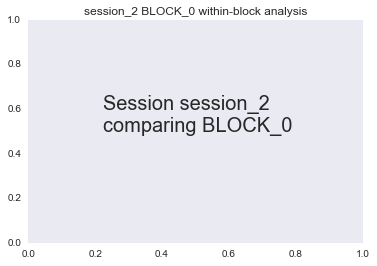

In [5]:
######## Get list of files (.mat) we want to work with ########
filedir = '../condensed_data_NIH034/blocks//'
sessions = os.listdir(filedir)
sessions = sessions[3:]

# loop through each session
for session in sessions:
    print "Analyzing session ", session
    sessiondir = filedir + session
    
    # get all blocks for this session
    blocks = os.listdir(sessiondir)

    # loop through each block one at a time, analyze
    for i in range(0, 6):
#         print "Analyzing block ", blocks[i]
        block = blocks[i]
        block_dir = sessiondir + '/' + block
        
        # in each block, get list of word pairs from first and second block
        wordpairs = os.listdir(block_dir)
       
        # within-groups analysis only has: SAME, REVERSE, DIFFERENT
        diff_word_group = []
        reverse_word_group = []
        same_word_group = []       
#         print "These are the wordpairs in this block: ", wordpairs
        #### plot meta information about which session and blocks we're analyzing
        fig=plt.figure()
        axes = plt.gca()
        ymin, ymax = axes.get_ylim()
        xmin, xmax = axes.get_xlim()
        plt.text((xmax-xmin)/4.5, (ymax-ymin)/2, r'Session %s %scomparing %s'%(session, '\n',block), fontsize=20)
        plt.title(session + ' ' + block + ' within-block analysis')
        plt.grid(False)
        
        ## 01: Create WordPair Groups
        # create same group pairs
        for idx, pair in enumerate(wordpairs):
            same_word_group.append([pair, pair])
        
        # create reverse, and different groups
        for idx, pairs in enumerate(itertools.combinations(wordpairs,2)):
            if isReverse(pairs[0], pairs[1]):
                reverse_word_group.append([pairs[0], pairs[1]])
            else:
                diff_word_group.append([pairs[0], pairs[1]])
        
        # initialize list of channels we want to look at
#         channels = os.listdir(block_dir+'/'+same_word_group[0][0]) # all channels
#         channels = high_session_chans[session] # high frequency impact channels
        channels = low_session_chans[session][0]
        print "Number of channels used: ", len(channels)
    
        # initialize dictionary and matrices for storing p-values after comparison of word groups
        session_block_pval_dict = {}
        session_block_pval_mat = np.array(())
        session_block_pval_same_mat = np.array(())
        session_block_pval_reverse_mat = np.array(())
        
        ## 02: Create feature_dicts from each channel

        ### Go through each group and extract the feature data for each wordpair comparison
        same_feature_dict = extractFeaturesForChannel(same_word_group,session,block,block_dir, channels, low_freq_bands)
        reverse_feature_dict = extractFeaturesForChannel(reverse_word_group,session,block,block_dir, channels, low_freq_bands)
        diff_feature_dict = extractFeaturesForChannel(diff_word_group,session,block,block_dir, channels, low_freq_bands)

        
        print "Finished Extracting."
        ######################################## SAME WORD PAIRS ########################################
#         plotAllHist(same_feature_dict)
        session_same_distances = groupAllRepeatedDistances(same_feature_dict)
        print len(session_same_distances)
        fig = plt.figure()
        ax = plt.gca()
        ax.grid(False)
        plt.hist(session_same_distances, color='k', lw=3)
        plt.xlabel('Cosine Similarity n='+str(len(session_same_distances)))
        plt.ylabel('Frequency Count')
        plt.title('Same Word Pairs: Within-block pairwise distances in ' + session + ' with ' + block)
        plt.xlim([-1,1])
        plt.legend(r'n= %s'%(str(len(session_same_distances))))
        plt.tight_layout()
    
        ######################################## REVERSED WORD PAIRS ########################################
#         plotAllHist(reverse_feature_dict)
        session_reverse_distances = groupAllDistances(reverse_feature_dict)
        print len(session_reverse_distances)
        fig = plt.figure()
        ax = plt.gca()
        ax.grid(False)
        plt.hist(session_reverse_distances, color='k', lw=3)
        plt.xlabel('Cosine Similarity n='+str(len(session_reverse_distances)))
        plt.ylabel('Frequency Count')
        plt.title('Reversed Word Pairs: Within-block pairwise distances in ' + session + ' with ' + block)
        plt.xlim([-1,1])
        plt.legend(r'n= %s'%(str(len(session_reverse_distances))))
        plt.tight_layout()
        
        ####################################### DIFFERENT WORD PAIRS ########################################        
#         plotAllHist(diff_feature_dict)
        session_diff_distances = groupAllDistances(diff_feature_dict)
        print len(session_diff_distances)
        fig = plt.figure()
        ax = plt.gca()
        ax.grid(False)
        plt.hist(session_diff_distances, color='k', lw=3)
        plt.xlabel('Cosine Similarity n='+str(len(session_diff_distances)))
        plt.ylabel('Frequency Count')
        plt.title('Different Word Pairs: Within-block pairwise distances in ' + session + ' with ' + block)
        plt.xlim([-1,1])
        plt.legend(r'n= %s'%(str(len(session_diff_distances))))
        plt.tight_layout()   
        
        
        ##### RUN STATS COMPARISONS ON SAME VS. REVERSE, SAME VS. DIFF, 
        random_subset = np.random.choice(range(session_same_distances.shape[0]), size=len(session_same_distances)/2, replace=False)
        random_subset2 = list(set(np.arange(0, len(session_same_distances))) - set(random_subset))
        same_X = session_same_distances[random_subset]
        same_Y = session_same_distances[random_subset2]
        
        stat, same_p_val = stats.ks_2samp(same_X, same_Y)
        stat, reverse_p_val = stats.ks_2samp(session_same_distances, session_reverse_distances)
        stat, diff_p_val = stats.ks_2samp(session_same_distances, session_diff_distances)
           
        stat, same_p_val = stats.ttest_ind(same_X, same_Y)
        stat, reverse_p_val = stats.ttest_ind(session_same_distances, session_reverse_distances)
        stat, diff_p_val = stats.ttest_ind(session_same_distances, session_diff_distances)
           
            
#         plotPowerSimulations(same_X, same_Y, 'Same WordPairs')
#         plotPowerSimulations(session_same_distances, session_reverse_distances, 'Reverse WordPairs')
#         plotPowerSimulations(session_same_distances, session_diff_distances, 'Different WordPairs')
            
        print "On block: ", block
        print "Same avg +/- std: %0.3f" %np.mean(session_same_distances), ' +/- %0.3f' %stats.sem(session_same_distances)
        print "Reverse avg +/- std: %0.3f" %np.mean(session_reverse_distances), ' +/- %0.3f' %stats.sem(session_reverse_distances)
        print "Different avg +/- std: %0.3f" %np.mean(session_diff_distances), ' +/- %0.3f' %stats.sem(session_diff_distances)
        print "Same vs. Same comparison: %0.3f" %same_p_val
        print "Same vs. Reverse Comparison: %0.3f" %reverse_p_val
        print "Same vs. Different Comparison: %0.3f" %diff_p_val

    break